In [13]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
import folium
import seaborn as sns
import road_data_manipulation_v2 as rdm
import aux_functions as aux

# Specifications - must be run

In [15]:
destination="/Users/oysteinbruce/Documents/GitHub/SINTEF/fuel_model/data/raw_2809"
date = '2021-10-14'

eventsFile = f'{destination}/{date}_to_{date}_events_preprocessed.h5'
trackingFile = f'{destination}/{date}_to_{date}_tracking_events_preprocessed.h5'

In [17]:
# Mapping dumper ids from motion data to fuel data
id_mapping = {'605c4727bf26243ac44fd169':352555108617496}

In [50]:
events = pd.read_hdf(eventsFile)
tracking_events = pd.read_hdf(trackingFile)
    

data_raw, proj_info = rdm.read_data(events, tracking_events)
tracking_index_DumperId = data_raw.DumperId_x == list(id_mapping.keys())[0]
data_raw = data_raw[tracking_index_DumperId]
data_raw['DumperId'] = data_raw['DumperId_x']
data_raw.drop(['DumperId_x', 'DumperId_y'], axis=1, inplace=True)
if len(data_raw) > 1:
     # Preprocess GPS data, removing first/last 30 meters of data (reversing of dumpers)
    data = rdm.trips_processing(data_raw, endpoint_threshold=0, remove_endpoints=False, 
                                         variables=list(data_raw.columns) + ['DistanceDriven'])
else:
    print('No data for the selected parameters')

### Get fuel data

In [51]:
filename = f'{destination}/{date}_to_{date}_fuel.h5'
fuel = pd.read_hdf(filename)
print(f'Fuel data loaded from {filename}')
fuel.info() 

Fuel data loaded from /Users/oysteinbruce/Documents/GitHub/SINTEF/fuel_model/data/raw_2809/2021-10-14_to_2021-10-14_fuel.h5
<class 'pandas.core.frame.DataFrame'>
Int64Index: 45891 entries, 0 to 15492
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   data       45891 non-null  object             
 1   data_Fuel  45891 non-null  float64            
 2   data_Time  45891 non-null  datetime64[ns, UTC]
 3   gpsTime    45891 non-null  int64              
 4   latitude   45891 non-null  float64            
 5   longitude  45891 non-null  float64            
 6   unitId     45891 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(3), int64(2), object(1)
memory usage: 2.8+ MB


## Add fuel data - Only relevant when merging data
Add fuel data to each trip after preprocessing but BEFORE splitting in graphs.

For each trip in the Ditio data, the corresponding time interval for the same dumper is assigned from the fuel data. The fuel data are converted from fuel rate to incremental fuel usage and resampled/interpolated to match the GPS data (we could consider DTW for this).

In [54]:
def add_fuel(tracking_subset: pd.core.frame.DataFrame,
             fuel_subset: pd.core.frame.DataFrame,
             TripLogIds: np.ndarray,
             id_mapping: dict,
             dev_outer_threshold: float,
             dev_points_threshold: float,
             interpolation_cols: list,
             ff_cols: list,
             plotting: bool):
    """
    Adding fuel information to motion dataframe. The fuel data are interpolated to match the motion data. 
    TODO? Try DTW?

    Parameters
    ----------
    tracking_subset : DataFrame 
        DataFrame with tracking data properties (TODO refer to proper class). 
        The function is not optimised for speed, so it's recommended that tracking_subset does not contain pings for trips not listed in TripLogIds.
    fuel_subset : DataFrame 
        DataFrame with fuel properties (TODO refer to proper class) for same time period as tracking_subset.
    TripLogIds : ndarray 
        Array containing TripLogIds.
    id_mapping : dict 
        Dictionary with mappings between dumper id in tracking_subset and fuel.
    dev_outer_threshold : float
       If min/max points are too far away from each other (in meter)
    dev_points_threshold : float
       If subsequent points are too far away from each other (in meter)
    interpolation_cols : list
        List of columns to be interpolated between the two dataframes.
    interpolation_cols : list
        List of columns to be forward filled between the two dataframes.



    Returns
    -------
    DataFrame
        tracking_subset DataFrame with fuel information
    """
    new_df = pd.DataFrame()
    for TripLogId in TripLogIds:
        #        for triptype in [0, 1, 2]: # type 0 is very often mis-aligned between fuel and ditio GPS data
        # & (tracking_subset.Type==triptype)]
        track = tracking_subset.loc[(tracking_subset.TripLogId == TripLogId)]
        anglemin, anglemax = 135, 225
        track['AngleChange'] = abs(track['Course'].diff())
        track['TimeDelta'] = (track['Timestamp'] -
                              track['Timestamp'].min()).dt.total_seconds()
        angle_index = (track.AngleChange > anglemin) & (
            track.AngleChange < anglemax)

        if len(track) > 0:
            # Preparing split in forward/backward motion
            track['TurningPoint'] = 0
            track.loc[angle_index, 'TurningPoint'] = 1
            track['subtrack'] = track['TurningPoint'].cumsum()

            starttime = track.Timestamp.min()
            endtime = track.Timestamp.max()
            fuel_index_time = (fuel_subset.data_Time > starttime) & (
                fuel_subset.data_Time < endtime)
            fuel_index_id = fuel_subset.unitId == id_mapping[track.iloc[0].DumperId]
            track_fuel = fuel_subset.loc[fuel_index_time &
                                         fuel_index_id].copy()

        # The two data sets have similar time resolution. Before interpolation we remove tracks with very differen
        #length_ratio = np.abs(len(track)-len(track_fuel))/len(track_fuel)
        #    if (length_ratio < threshold_fraction) & (len(track_fuel) > 10):
        # lengths as a simple way of getting rid of problematic data.

        # The euclidian distance between deviation of outer points defining the tracks
            dev_outer = np.sqrt((track.x.min()-track_fuel.x.min())**2 + (track.x.max()-track_fuel.x.max())**2 +
                                (track.y.min()-track_fuel.y.min())**2 + (track.y.max()-track_fuel.y.max())**2)

            # The max distance between to subsequent coordinates in the GPS data
            dev_points = np.sqrt((track.x.diff()**2 + track.x.diff()**2).max())
            if (dev_outer < dev_outer_threshold) & (dev_points < dev_points_threshold) & (len(track_fuel) > 10):
                track_fuel.loc[:, 'TimeDiff'] = track_fuel['data_Time'].diff(
                ).dt.total_seconds()
                track_fuel.loc[:, 'FuelFromPrevious'] = track_fuel['data_Fuel'] / \
                    3600*track_fuel['TimeDiff']
                track_fuel.loc[:,
                               'FuelCumsum'] = track_fuel['FuelFromPrevious'].cumsum()
                track.loc[:, 'DistanceCumsum'] = track.Distance.cumsum()
                df1 = track_fuel.set_index('data_Time')
                df2 = track.set_index('Timestamp')

                merged = aux.merge_resample_interpolate(df1.drop(['x', 'y'], axis=1), df2,
                                                        interpolation_cols=interpolation_cols,
                                                        ff_cols=ff_cols, frequency='s', plotting=False)


#                Compute differences so the quantities become comparable -> fuel per time unit and distance per time unit -> STATS
                merged.loc[:, 'DistanceCumsumDiff'] = merged.loc[:,
                                                                 'DistanceCumsum'].diff()
                merged.loc[:, 'FuelCumsumDiff'] = merged.loc[:,
                                                             'FuelCumsum'].diff()
                merged.loc[:, 'Timestamp'] = merged.index
                merged.loc[:, 'TimeDelta'] = (
                    merged['Timestamp']-merged['Timestamp'].min()).dt.total_seconds()

                forward_threshold_velocity = 2.5  # Ask Jacob about tuning of these
                forward_threshold_distance = 50
                forward_threshold_time = 30

                kmax = int(merged.subtrack.max())
                merged['Forward'] = np.nan

                for k in range(kmax):
                    subtrack_index = merged.subtrack == k
                    subtrack = merged[subtrack_index].copy()
                    subtrack['DistanceCumsum'] = subtrack['DistanceCumsum'] - \
                        subtrack['DistanceCumsum'].min()
                    subtrack['TimeDelta'] = (
                        subtrack['Timestamp']-subtrack['Timestamp'].min()).dt.total_seconds()
                    if (subtrack.Speed.max() > forward_threshold_velocity) \
                        & (subtrack.DistanceCumsum.max() > forward_threshold_distance) \
                            & (subtrack.TimeDelta.max() > forward_threshold_time):
                        merged.loc[subtrack_index, 'Forward'] = 1
                    else:
                        merged.loc[subtrack_index, 'Forward'] = 0

                # TODO: here Bruce comes in
                # Split if not getting fuel data in some time, split into two different ID's
                df1['diff_time'] = df1.index.to_series().diff().dt.total_seconds()
                df1[df1.diff_time > 10]

                # Split if fuel do not change, when x, y change (from fuel data)
                df1['diff_xy'] = abs(df1.y.diff()).fillna(
                    0) + abs(df1.x.diff()).fillna(0)
                df1['diff_xy_diff'] = df1.diff_xy.diff()
                df1['diff_data_Fuel'] = df1.data_Fuel.diff()

                # Says how much it has been moving the last few points
                df1['stand_still'] = (df1.diff_xy[:] + df1.diff_xy[1:].shift(
                    1) + df1.diff_xy[2:].shift(2) + df1.diff_xy[3:].shift(3)).fillna(0)

                # Says how much fuel usage have changed for a while
                df1['stand_still_fuel'] = (df1.diff_data_Fuel[:] + df1.diff_data_Fuel[1:].shift(1) +
                                           df1.diff_data_Fuel[2:].shift(2) + df1.diff_data_Fuel[3:].shift(3) +
                                           df1.diff_data_Fuel[4:].shift(4) + df1.diff_data_Fuel[5:].shift(5) +
                                           df1.diff_data_Fuel[6:].shift(6) + df1.diff_data_Fuel[7:].shift(7) +
                                           df1.diff_data_Fuel[8:].shift(8) + df1.diff_data_Fuel[8:].shift(8))

                # if fuel doesn't have changed, when going from standing still to moving - then set fail
                df1['fuel_data_fails'] = (
                    df1.stand_still_fuel == 0) & (df1.stand_still > 2)

                # MOVING, but the fuel hasn't reacted yet
                time_slots = df1.index[df1['fuel_data_fails'].diff().fillna(
                    0).astype('int') == 1]

                # adding the first and last time, for easier splitting of the code
                time_slots = time_slots.insert(0, df2.index[0])
                time_slots = time_slots.insert(len(time_slots), df2.index[-1])

                # MOVING, but the fuel hasn't reacted yet
                if len(time_slots) > 2:  # if there is moving but fuel hasn't reacted yet
                    # TODO: delete
                    print("GOING FOR ANOTHER ROUND")
                    new_trip_log_ids = []

                    # First one is good
                    for i in range(0, len(time_slots), 2):
                        trip_log_id = df2.TripLogId[str(time_slots[i]):str(
                            time_slots[i+1])][0] + f'__{i}'
                        new_trip_log_ids.append(trip_log_id)
                        df2.TripLogId[str(time_slots[i]):str(
                            time_slots[i+1])] = trip_log_id

                        # Switch to the correc pd.dataframe to send further
                        track.TripLogId = df2.TripLogId.values

                    splitted_merged = add_fuel(tracking_subset=track,
                                               fuel_subset=fuel_subset,
                                               TripLogIds=new_trip_log_ids,
                                               id_mapping=id_mapping,
                                               dev_outer_threshold=50,
                                               dev_points_threshold=50,
                                               interpolation_cols=interpolation_cols,
                                               ff_cols=ff_cols,
                                               plotting=True)

                    new_df = new_df.append(splitted_merged)

                else:
                    # TODO: when spliting, just send the splitted information into

                    # TODO: maybe add, if much fuel for a while after no movement also.

                    # TODO: not always add, just if no changes above
                    new_df = new_df.append(merged)

                if plotting & (len(time_slots) == 2):
                    if (dev_outer < dev_outer_threshold) & (dev_points < dev_points_threshold) & (len(track_fuel) > 10):

                        N = 6
                        fig, axs = plt.subplots(1, N, figsize=(5*N, 6))
                        fig.suptitle(
                            f'{TripLogId} outer dev: {dev_outer:.0f}  Points dev: {dev_points:.0f}', fontsize=16)

                        # x, y
                        i = 0
                        axs[i].scatter(
                            df2.x, df2.y, label=f'gps {df2.x.mean():.0f} {df2.y.mean():.0f}')
                        axs[i].scatter(
                            df2.iloc[0].load_x, df2.iloc[0].load_y, label=f'gps load', marker='v')
                        axs[i].scatter(
                            df2.iloc[0].dump_x, df2.iloc[0].dump_y, label=f'gps dump', marker='x')
                        axs[i].scatter(
                            df1.x, df1.y, label=f'fuel {df1.x.mean():.0f} {df1.y.mean():.0f}')
                        axs[i].ticklabel_format(style='plain')
                        axs[i].set_ylabel('y')
                        axs[i].set_xlabel('x')
                        df1.loc[:, 'TimeDelta'] = (
                            df1.index-df1.index.min()).total_seconds().values
                        df2.loc[:, 'TimeDelta'] = (
                            df2.index-df2.index.min()).total_seconds().values

                        # raw fuel vs merged fuel
                        i_fuel = i = 1
                        axs[i].scatter(df1.TimeDelta, df1.FuelCumsum, s=50,
                                       label='raw fuel', marker='x', color='black')
                        axs[i].plot(merged.TimeDelta, merged.FuelCumsum,
                                    label='merged', alpha=0.5)
                        axs[i].set_xlabel('Time [s]')
                        axs[i].set_ylabel('FuelCumsum')

                        # raw distance vs merged distance
                        i_dist = i = 2
                        axs[i].plot(df2.TimeDelta, df2.DistanceCumsum,
                                    label='raw gps', alpha=0.5, linestyle='dashed')
                        axs[i].plot(
                            merged.TimeDelta, merged.DistanceCumsum, label='merged', alpha=0.5)
                        axs[i].set_xlabel('Time [s]')
                        axs[i].set_ylabel('DistanceCumsum')

                        # Course
                        i = 3
#                            axs[i].scatter(merged.TimeDelta, merged.Course, label=f'Course')
                        axs[i].scatter(merged.TimeDelta,
                                       merged.Course_ff, label=f'Course ff')

#                            axs[-3].scatter(merged.TimeDiff, merged.AngleChange, label=f'AngleChange')
                        axs[i].scatter(track.loc[angle_index].TimeDelta, track.loc[angle_index].AngleChange,
                                       marker='D', color='black')
                        axs[i].scatter(track.TimeDelta, track.AngleChange,
                                       marker='o', alpha=0.5)
                        axs[i].axhline(360)
                        axs[i].axhline(anglemin)
                        axs[i].axhline(anglemax)
                        axs[i].set_xlabel('Time [s]')
                        axs[i].set_ylabel('Course')

                        # Velocity
                        i_vel = i = 4
                        axs[i].axhline(forward_threshold_velocity)
                        axs[i].scatter(track.loc[angle_index].TimeDelta, track.loc[angle_index].Speed,
                                       marker='D', color='black')

                        axs[i].set_xlabel('Time [s]')
                        axs[i].set_ylabel('Speed')

                        # x, y subtracks
                        i = 5

                        for k in merged.subtrack.unique():
                            subtrack = merged[merged.subtrack == k]
                            if subtrack.iloc[0].Forward == 1:
                                marker = 'x'
                            else:
                                marker = 'o'
                            axs[i].scatter(
                                subtrack.x, subtrack.y, label=subtrack.Type.mean(), marker=marker)
                            axs[i_vel].scatter(
                                subtrack.TimeDelta, subtrack.Speed, marker=marker, label=subtrack.DistanceCumsum.max())
                            axs[i_fuel].scatter(
                                subtrack.TimeDelta, subtrack.FuelCumsum, marker=marker, alpha=0.2, label=k)
                            axs[i_dist].scatter(
                                subtrack.TimeDelta, subtrack.DistanceCumsum, marker=marker, alpha=0.2, label=k)

                        for i in range(N):
                            axs[i].legend()

                        plt.savefig(f'tmp/{TripLogId}_012.png')
                        plt.close()
                else:
                    print('Will not plot, because the route has been splitted')

    return new_df


In [18]:
merge_tracks = 1

if merge_tracks==1:
    tracking_subset = data.copy().drop('index', axis=1)
    fuel_subset = aux.get_fuel_subset(fuel, tracking_subset, id_mapping)
    fuel_subset, _ = rdm.add_meter_columns(fuel_subset, proj_info=proj_info, 
                                    load=False, dump=False, latlon_varnames = ['latitude', 'longitude'])

    #check_cols ['Distance', 'DistanceDriven']
    interpolation_cols = ['FuelCumsum', 'Longitude', 'Latitude', 'Altitude', 'DistanceCumsum', 'Speed', 'x', 'y', 'Course']
    ff_cols = ['TripLogId', 'Type', 'DumperId', 'DumperMachineName', 'DumperMachineTypeId', 
           'LoaderId', 'LoaderMachineName', 'LoaderMachineTypeId'
           'CompanyId', 'ProjectCompanyId', 'ProjectId', 'ProjectNumber', 'ProjectExternalNumber', 'ProjectName', 'TaskId', 'TaskDescription',
           'HorizontalAccuracy', 'VerticalAccuracy',
           'LoadDateTime', 'DumpDateTime', 'MassTypeId', 'MassTypeName',
           'MassTypeMaterial', 'Quantity', 'LoadGeoFenceId', 'DumpGeoFenceId',
           'LoadLatitude', 'LoadLongitude', 'LoadHorizontalAccuracy',
           'DumpLatitude', 'DumpLongitude', 'DumpHorizontalAccuracy',
           'LoadGeoFenceLongitudes', 'LoadGeoFenceLatitudes',
           'DumpGeoFenceLongitudes', 'DumpGeoFenceLatitudes',
           'load_x', 'load_y', 'dump_x', 'dump_y', 'Course_ff', 'subtrack']

# Change so ffill for all that's not interpolated?

    
    tracking_subset['Course_ff'] = tracking_subset['Course'].values
    TripLogIds = tracking_subset.TripLogId.unique()
    merged = add_fuel(tracking_subset=tracking_subset, 
                  fuel_subset=fuel_subset,
                  TripLogIds=TripLogIds,
                  id_mapping=id_mapping,
                  dev_outer_threshold = 50,
                  dev_points_threshold = 50,
                  interpolation_cols=interpolation_cols,
                  ff_cols=ff_cols, 
                  plotting=True)
    filename = f'{destination}/{date}_to_{date}_merged.h5'
    
    merged.to_hdf(filename, key='merged')
else:
    filename = f'{destination}/{date}_to_{date}_merged.h5'
    merged = pd.read_hdf(filename)
    print(f'Merged data loaded from {filename}')


NameError: name 'data' is not defined

# Load data from multiple dates of merged data - Start here

In [38]:
destination="/Users/oysteinbruce/Documents/GitHub/SINTEF/fuel_model/data/raw_2809"
dates = [
        '2021-09-28',
        '2021-09-29',
        # '2021-10-11',
        '2021-10-13',
        '2021-10-14',
        '2021-10-15',
        '2021-10-18',
        '2021-10-19',
        '2021-10-20',
        '2021-10-21',
    ]
# dates = ['2021-10-15', '2021-10-14', '2021-10-13', '2021-10-12',
#         '2021-10-06','2021-10-05','2021-10-04']

merged = pd.DataFrame()

for date in dates:
    filename = f'{destination}/{date}_to_{date}_merged.h5'
    merged_date = pd.read_hdf(filename)
    print(date, len(merged_date.TripLogId.unique()))
    merged = merged.append(merged_date)
    

2021-09-28 57
2021-09-29 21
2021-10-13 37
2021-10-14 40
2021-10-15 22
2021-10-18 11
2021-10-19 55
2021-10-20 29
2021-10-21 33


<ipython-input-38-64489a9feebd>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged = merged.append(merged_date)
<ipython-input-38-64489a9feebd>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged = merged.append(merged_date)
<ipython-input-38-64489a9feebd>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged = merged.append(merged_date)
<ipython-input-38-64489a9feebd>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged = merged.append(merged_date)
<ipython-input-38-64489a9feebd>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  m

In [39]:
merged.columns

Index(['FuelCumsum', 'data_Fuel', 'Longitude', 'Latitude', 'Altitude',
       'DistanceCumsum', 'Speed', 'x', 'y', 'Course', 'TripLogId', 'Type',
       'DumperId', 'DumperMachineName', 'DumperMachineTypeId', 'LoaderId',
       'LoaderMachineName', 'ProjectCompanyId', 'ProjectId', 'ProjectNumber',
       'ProjectExternalNumber', 'ProjectName', 'TaskId', 'TaskDescription',
       'HorizontalAccuracy', 'VerticalAccuracy', 'LoadDateTime',
       'DumpDateTime', 'MassTypeId', 'MassTypeName', 'MassTypeMaterial',
       'Quantity', 'LoadGeoFenceId', 'DumpGeoFenceId', 'LoadLatitude',
       'LoadLongitude', 'LoadHorizontalAccuracy', 'DumpLatitude',
       'DumpLongitude', 'DumpHorizontalAccuracy', 'LoadGeoFenceLongitudes',
       'LoadGeoFenceLatitudes', 'DumpGeoFenceLongitudes',
       'DumpGeoFenceLatitudes', 'load_x', 'load_y', 'dump_x', 'dump_y',
       'Course_ff', 'subtrack', 'DistanceCumsumDiff', 'FuelCumsumDiff',
       'Timestamp', 'TimeDelta', 'Forward', 'data_Fuel_v2'],
      dtype

### Data quality inspection and filtering

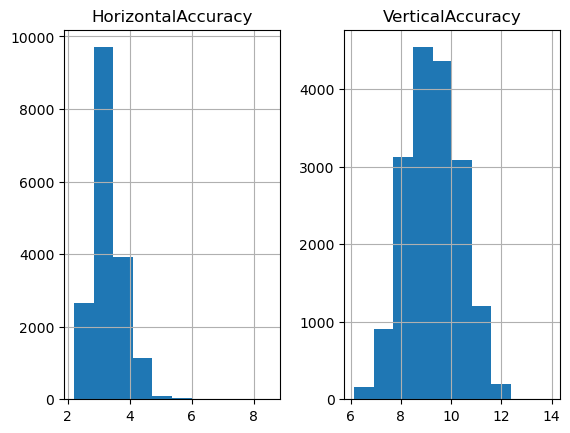

In [6]:
merged[['HorizontalAccuracy', 'VerticalAccuracy']].describe()
merged[['HorizontalAccuracy', 'VerticalAccuracy']].hist()
plt.show()

In [7]:
# Removing pings while reversing
merged_forward = merged[merged.Forward > 0].copy()


# Quantity is stored per trip and not per trip type. Hence we reset quantity to 0 for all type 0 and 2 to 0
index = merged_forward.Type.isin([0, 2])
merged_forward.loc[index, 'Quantity'] = 0

Number of unique subtracks before cutting: 237


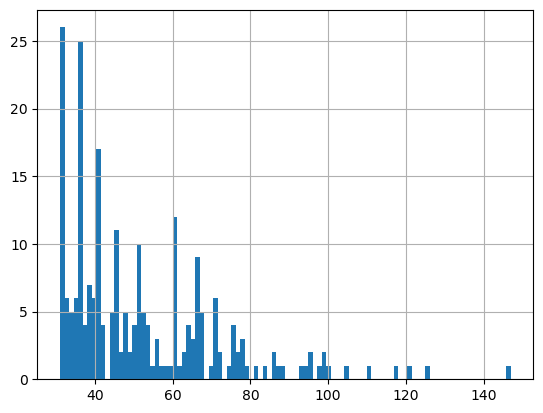

Number of unique subtracks after cutting: 237
Number of data points: 12352
Max unique trips: 330


In [11]:
# Check distribution of trips with only forward motion:
# Creating new triplogid that splits at subtrack
merged_forward['TypeTripLogId'] = merged_forward['TripLogId'] + '_' + merged_forward['subtrack'].astype('int').astype('str')


# Removing very long trips
print(f'Number of unique subtracks before cutting: {len(merged_forward.TypeTripLogId.unique())}')
merged_group = merged_forward.groupby('TypeTripLogId').size()
merged_group.hist(bins=100)
plt.show()

# plot longest trip   
trip = merged_forward[merged_forward.TypeTripLogId == merged_group.idxmax()].copy()
# fig, ax = plt.subplots(1,1)
# ax.scatter(trip.x, trip.y)

# cap long trips TODO: is this needed
threshold = 500
capped = merged_group[merged_group < threshold] 
merged_forward = merged_forward[merged_forward.TypeTripLogId.isin(capped.index)].copy()
print(f'Number of unique subtracks after cutting: {len(merged_forward.TypeTripLogId.unique())}')
print(f'Number of data points: {len(merged_forward)}')

print(f'Max unique trips: {np.sum(merged_group // 30)}')


In [12]:
merged_forward.TripLogId

2021-09-28 05:23:11+00:00    6152a553f41e8b0000350df3__0
2021-09-28 05:23:12+00:00    6152a553f41e8b0000350df3__0
2021-09-28 05:23:13+00:00    6152a553f41e8b0000350df3__0
2021-09-28 05:23:14+00:00    6152a553f41e8b0000350df3__0
2021-09-28 05:23:15+00:00    6152a553f41e8b0000350df3__0
                                        ...             
2021-10-21 17:34:27+00:00    6171a3728a0ed700009f5ce6__0
2021-10-21 17:34:28+00:00    6171a3728a0ed700009f5ce6__0
2021-10-21 17:34:29+00:00    6171a3728a0ed700009f5ce6__0
2021-10-21 17:34:30+00:00    6171a3728a0ed700009f5ce6__0
2021-10-21 17:34:31+00:00    6171a3728a0ed700009f5ce6__0
Name: TripLogId, Length: 12352, dtype: object

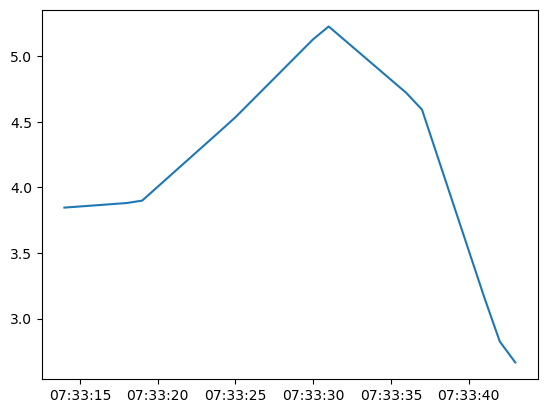

2021-09-28 07:33:14+00:00         NaN
2021-09-28 07:33:15+00:00    0.008746
2021-09-28 07:33:16+00:00    0.008746
2021-09-28 07:33:17+00:00    0.008746
2021-09-28 07:33:18+00:00    0.008746
2021-09-28 07:33:19+00:00    0.018254
2021-09-28 07:33:20+00:00    0.105765
2021-09-28 07:33:21+00:00    0.105765
2021-09-28 07:33:22+00:00    0.105765
2021-09-28 07:33:23+00:00    0.105765
2021-09-28 07:33:24+00:00    0.105765
2021-09-28 07:33:25+00:00    0.107055
2021-09-28 07:33:26+00:00    0.118922
2021-09-28 07:33:27+00:00    0.118922
2021-09-28 07:33:28+00:00    0.118922
2021-09-28 07:33:29+00:00    0.118922
2021-09-28 07:33:30+00:00    0.118922
2021-09-28 07:33:31+00:00    0.097318
2021-09-28 07:33:32+00:00   -0.101524
2021-09-28 07:33:33+00:00   -0.101524
2021-09-28 07:33:34+00:00   -0.101524
2021-09-28 07:33:35+00:00   -0.101524
2021-09-28 07:33:36+00:00   -0.101524
2021-09-28 07:33:37+00:00   -0.126593
2021-09-28 07:33:38+00:00   -0.357331
2021-09-28 07:33:39+00:00   -0.357331
2021-09-28 0

In [13]:
# merged_forward.TypeTripLogId.str.contains('616925856cdefc0000210b5e__0')
# merged_forward['2021-10-15 15:00:39+00:00':'2021-10-18 16:00:39+00:00 ']
merged_forward.columns
driving = merged_forward.Speed[240:270]
plt.plot(driving)
plt.show()
print(driving.diff())
# print(merged_forward['Speed'].diff()[:10])
# print(merged_forward['Speed'][:10])


## Compute statistics

In [6]:
import helper

In [57]:
# Run the sampling and select some trips to plot
TripTypes = [0,1,2]
TypeTripLogIds = None
#['6168400dfd6b890000082df2_1']
statdata = helper.sample_trips(merged_forward, trip_types=TripTypes,
                 minlength = 30,
                 maxlength = 30,
                 Nsamples = 1000,
                 TypeTripLogIds = TypeTripLogIds,
                 idling_threshold = 1,
                 acceleration_threshold = 0.01,
                 altitude_threshold = .01,
                 Nplots = 0,
                 half_unique = True,
                 fully_unique = False)



## Correlation matrix ++ 

In [12]:
statdata.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = ['Type', 'LengthTime',
       'LengthDistance', 'SpeedMean', 'SpeedVariance', 'Quantity',
       'SpeedDiffPositiveSum', 'AccFuel', 'AccTime', 'SpeedDiffNegativeSum',
       'AltitudeLoss', 'AltitudeGain', 'AltitudeDeltaEndStart',
       'AltitudeDeltaMaxMin', 'DownInclination', 'UpInclination',
       'IdlingTime', 'IdlingFuel', 'SumRotation', 'Fuel',
       'FuelPerTonPerMeter', 'Sum_RotationXAltitudeDiffPos', 'Sum_RotationXAltitudeDiffNeg', 'AltitudeChange', 'AccTime']
       
for col in cols:
    plt.hist(statdata[col], bins=50)
    plt.xlabel(col)
    plt.show()

excluded_statdata = statdata.copy()
set_columns = ['outliers', 'ControlStartTime', 'DistanceFullyRoute', 'Month', 
            'DownInclinationPart', 'UpInclinationPart', 'AccFuel', 
            'FuelPerTonPerMeter', 'Sum_RotationXAltitudeDiffNeg', 'Sum_RotationXAltitudeDiffPos', 
            'SpeedVariance', 'Type', 'SpeedDiffNegativeSum', 'IdlingTime', 'IdlingFuel', 'IdlingFuel',
            'MAX_speedMean_altitudeLossPart', 'MIN_speedMean_altitudeGainPart', 'SpeedDiffPositiveSum',
            'LengthTime', 'MAX_speedMean_altitudeGainPart']

excluded_statdata = excluded_statdata.loc[:, ~excluded_statdata.columns.isin(set_columns)]

NameError: name 'statdata' is not defined

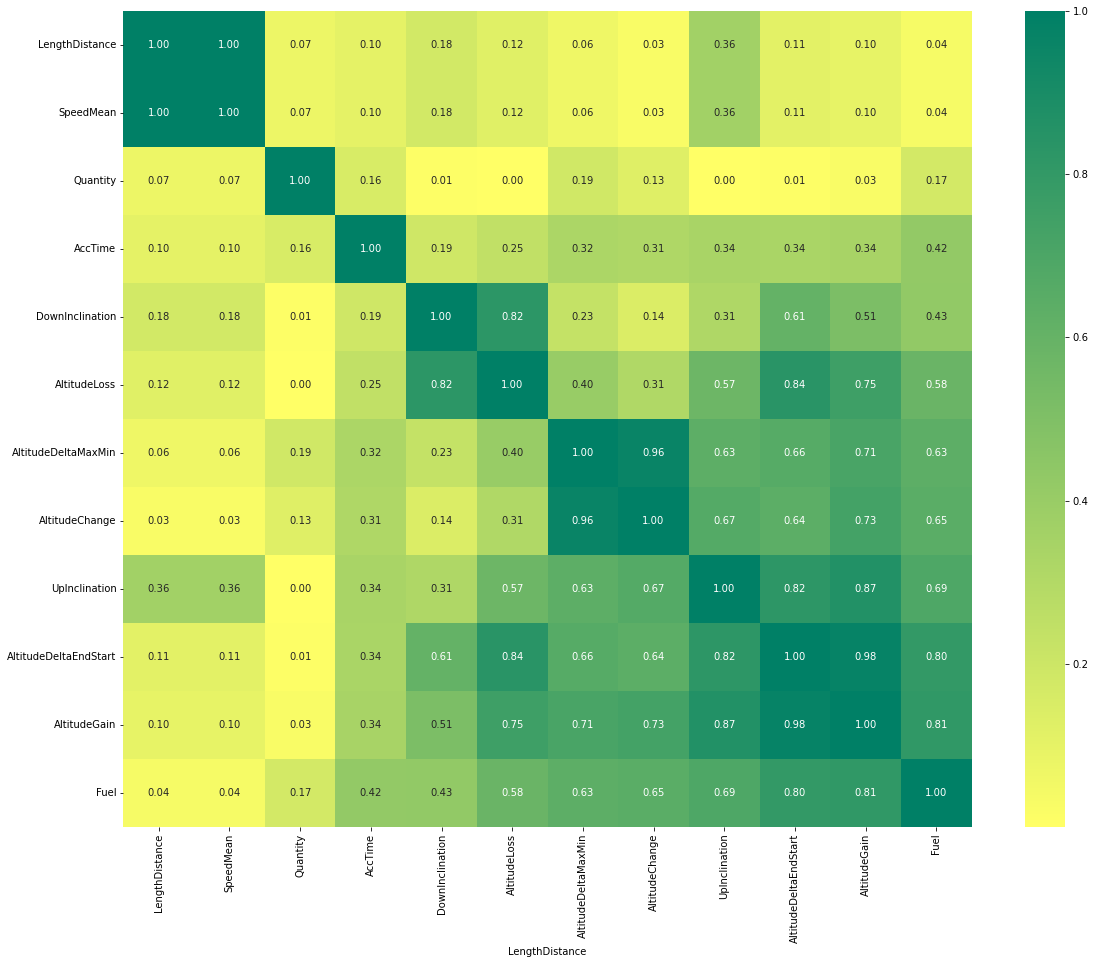

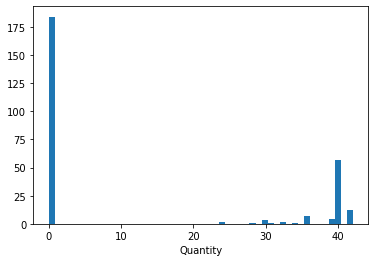

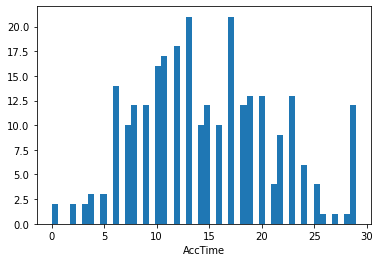

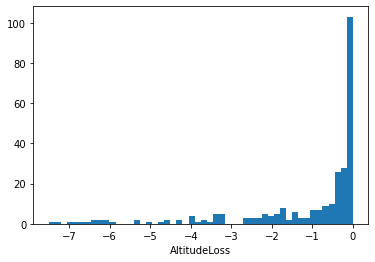

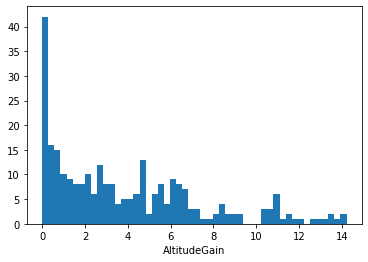

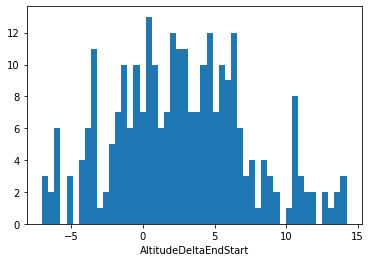

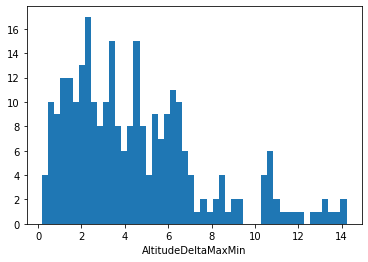

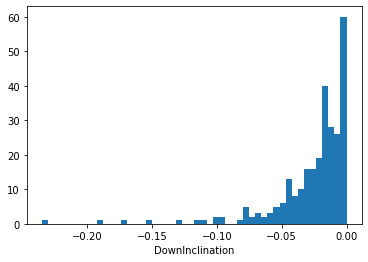

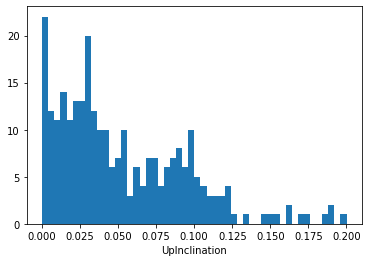

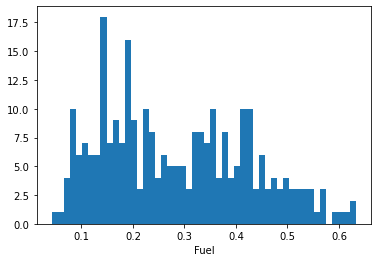

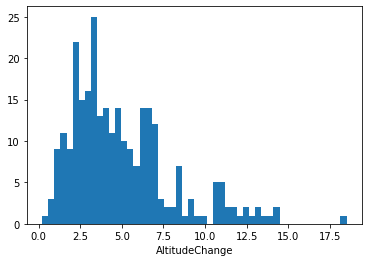

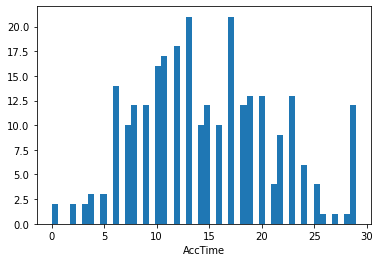

In [22]:
set_columns = ['outliers', 'ControlStartTime', 'DistanceFullyRoute', 'Month', 
            'DownInclinationPart', 'UpInclinationPart', 'AccFuel', 
            'FuelPerTonPerMeter', 'Sum_RotationXAltitudeDiffNeg', 'Sum_RotationXAltitudeDiffPos', 
            'SpeedVariance', 'Type', 'SpeedDiffNegativeSum', 'IdlingTime', 'IdlingFuel', 'IdlingFuel',
            'MAX_speedMean_altitudeLossPart', 'MIN_speedMean_altitudeGainPart', 'SpeedDiffPositiveSum',
            'LengthTime', 'MAX_speedMean_altitudeGainPart', 'AltitudeGainPart', 'AltitudeLossPart', 'SumRotation']
# Get the fixed data set
fixed_statdata = helper.get_df_of_statistics(dates, 'fully_unique')[0]
fixed_statdata.replace([np.inf, -np.inf], np.nan, inplace=True)


cols = [
       'LengthDistance', 'Quantity',
        'AccTime', 
       'AltitudeLoss', 'AltitudeGain', 'AltitudeDeltaEndStart',
       'AltitudeDeltaMaxMin', 'DownInclination', 'UpInclination',
       'Fuel',
       'AltitudeChange', 'AccTime']
fixed_statdata = fixed_statdata.loc[:, ~fixed_statdata.columns.isin(set_columns)]
%matplotlib inline

# Create correlation matrix
corr_matrix = fixed_statdata.corr(method='spearman')
#display(corr_matrix)
ind = corr_matrix.Fuel.abs().sort_values().index
corr_matrix = fixed_statdata[ind].corr(method='spearman')
# Plot
fig, axs = plt.subplots(1, 1, figsize=(19, 15))
sns.heatmap(abs(corr_matrix), annot=True, cmap = plt.cm.summer_r, fmt='.2f', ax=axs)
#axs.set_ylim(0, len(corr_matrix))merged['Quantity']

# cols = ['Type',
#        'LengthDistance', 'SpeedMean', 'SpeedVariance', 'Quantity',
#        'SpeedDiffPositiveSum', 'AccFuel', 'AccTime', 'SpeedDiffNegativeSum',
#        'AltitudeLoss', 'AltitudeGain', 'AltitudeDeltaEndStart',
#        'AltitudeDeltaMaxMin', 'DownInclination', 'UpInclination',
#        'IdlingTime', 'IdlingFuel', 'SumRotation', 'Fuel', 'AltitudeChange']
       
for col in cols:
    plt.hist(fixed_statdata[col], bins=50)
    plt.xlabel(col)
    plt.show()



In [23]:
# Plotting individual

# sample_trips(merged, trip_types=TripTypes,
#                 minlength = 30,
#                 maxlength = 300,
#                 Nsamples = 1000,
#                 TypeTripLogIds = ['6168400dfd6b890000082df2_1'],
#                 idling_threshold = 1,
#                 acceleration_threshold = 0.01,
#                 altitude_threshold = .01,
#                 Nplots = 4)

# statdata.iloc[statdata.Fuel.idxmax()].

In [15]:
%matplotlib inline

# Create correlation matrix
corr_matrix = excluded_statdata.corr(method='spearman')
#display(corr_matrix)
ind = corr_matrix.Fuel.abs().sort_values().index
corr_matrix = excluded_statdata[ind].corr(method='spearman')
# Plot
fig, axs = plt.subplots(1, 1, figsize=(19, 15))
sns.heatmap(abs(corr_matrix), annot=True, cmap = plt.cm.summer_r, fmt='.2f', ax=axs)
#axs.set_ylim(0, len(corr_matrix))merged['Quantity']

NameError: name 'excluded_statdata' is not defined

In [38]:
length = excluded_statdata['LengthDistance']
fuel = excluded_statdata['Fuel']

<AxesSubplot:>

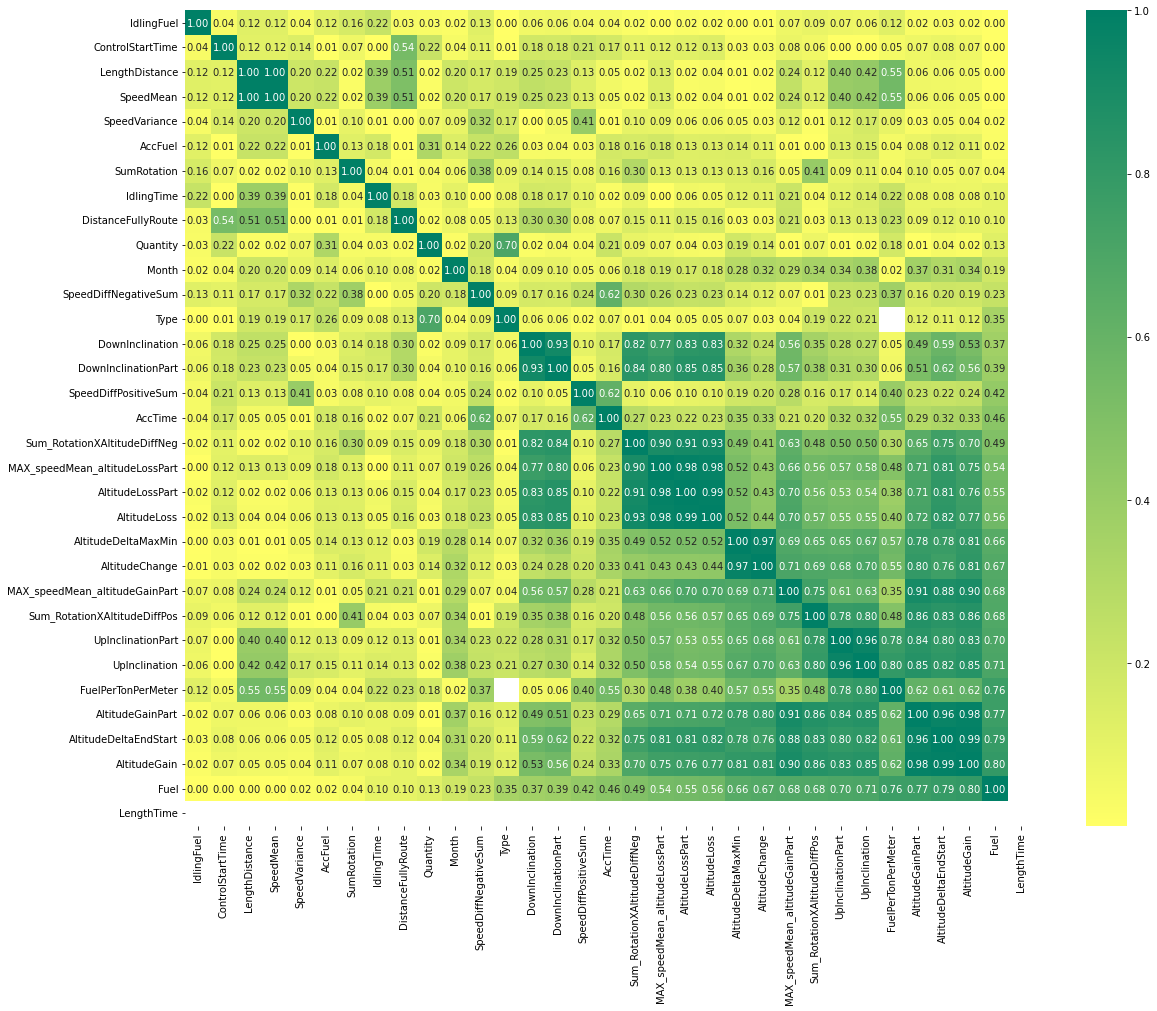

In [65]:
%matplotlib inline

# Create correlation matrix
corr_matrix = statdata.corr(method='spearman')
#display(corr_matrix)
ind = corr_matrix.Fuel.abs().sort_values().index
corr_matrix = statdata[ind].corr(method='spearman')
# Plot
fig, axs = plt.subplots(1, 1, figsize=(19, 15))
sns.heatmap(abs(corr_matrix), annot=True, cmap = plt.cm.summer_r, fmt='.2f', ax=axs)
#axs.set_ylim(0, len(corr_matrix))merged['Quantity']

In [34]:
plot_flag = 0

if plot_flag == 1:
    plot_data = statdata.drop(['Month'], axis=1).copy()
    print(plot_data.columns)
    # Visualising data dependencies with seaborn, might take a while to run, doesn't work for N>100-ish
    # Create the pairgrid object
    grid = sns.PairGrid(data=plot_data, diag_sharey=False)

    # Upper is a scatter plot
    grid.map_lower(plt.scatter, alpha=0.8, s=20)

    # Diagonal is a histogram
    grid.map_diag(sns.kdeplot)
    # Bottom is density plot
    #grid.map_upper(sns.kdeplot)
    #plt.savefig('/gridmap.pdf')
    plt.show()

In [35]:
print(f'{statdata[statdata.Quantity == 0].Fuel.mean(): .3f}: Mean fuel while driving without mass')
print(f'{statdata[statdata.Quantity > 0].Fuel.mean(): .3f}: Mean fuel while driving with mass')

 0.252: Mean fuel while driving without mass
 0.346: Mean fuel while driving with mass


## Idling Fuel vs acc fuel

In [36]:
# plt.hist(statdata.IdlingFuel, bins=50)
# print(statdata.IdlingFuel.sum(), (statdata.IdlingFuel/statdata.Fuel).mean())
# print(statdata.AccFuel.sum(), (statdata.AccFuel/statdata.Fuel).mean())

# Data processing

In [37]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # Feature scaling
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Data processing

In [43]:
# Selecting some control values, for control of bad predictions
X_feat_all = ['LengthDistance', #'LengthTime',
        'Quantity', #'Type',  
        'AltitudeGain', 'AltitudeLoss', 'AltitudeDeltaEndStart', 'AltitudeChange',
        'AltitudeDeltaMaxMin',
        'Sum_RotationXAltitudeDiffPos', 'Sum_RotationXAltitudeDiffNeg',
        #'DownInclination', 'UpInclination',
        #'Fuel',
         #'AccTime',
        'SpeedMean', # 'SpeedVariance', 
         #'SpeedDiffPositiveSum', 'SpeedDiffNegativeSum', 
         #'IdlingTime', 'SumRotation',
         'SumRotation', 'TypeTripLogId', 'DistanceFullyRoute', 'ControlStartTime', 'ControlStartTimeClock' 
        ]


y_feat = ['Fuel']
X_train_fact, X_test_fact, y_train, y_test = train_test_split(statdata[X_feat_all], statdata[y_feat], test_size=0.10, random_state=42)

# The actual features the model will take as input
X_feat = [#'LengthDistance', #'LengthTime',
        'Quantity', #'Type',  
        'AltitudeGain', 'AltitudeLoss', 'AltitudeDeltaEndStart', #'AltitudeChange',
        #'AltitudeDeltaMaxMin',
        #'Sum_RotationXAltitudeDiffPos', 'Sum_RotationXAltitudeDiffNeg',
        #'DownInclination', 'UpInclination',
        #'Fuel',
         #'AccTime',
        'SpeedMean', # 'SpeedVariance', 
         #'SpeedDiffPositiveSum', 'SpeedDiffNegativeSum', 
         #'IdlingTime', 'SumRotation',
        #  'SumRotation'
        ]

# X_feat = [#'LengthDistance', #'LengthTime',
#         'Quantity', #'Type',  
#         'AltitudeGain', 'AltitudeLoss', 'AltitudeDeltaEndStart', #'AltitudeChange',
#         #'AltitudeDeltaMaxMin',
#         #'Sum_RotationXAltitudeDiffPos', 'Sum_RotationXAltitudeDiffNeg',
#         #'DownInclination', 'UpInclination',
#         #'Fuel',
#          #'AccTime',
#         'SpeedMean', # 'SpeedVariance', 
#          #'SpeedDiffPositiveSum', 'SpeedDiffNegativeSum', 
#          #'IdlingTime', 'SumRotation',
#          'SumRotation'
#         ]

X_train = X_train_fact[X_feat]
X_test = X_test_fact[X_feat]

In [44]:
# Feature scaling
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train_scaled = pd.DataFrame(sc_X.fit_transform(X_train.values), columns=X_feat)
y_train_scaled = pd.DataFrame(sc_y.fit_transform(y_train.values), columns=y_feat).values
X_test_scaled = pd.DataFrame(sc_X.transform(X_test.values), columns=X_feat)
y_test_scaled = pd.DataFrame(sc_y.transform(y_test.values), columns=y_feat)
y_train = y_train.values

index = y_test_scaled.sort_values('Fuel').index
X_test_scaled_sorted = X_test_scaled.iloc[index]

y_test_scaled_sorted = y_test_scaled.iloc[index].values.flatten()

# TODO: unscaled variants - may delete
y_test_sorted = y_test.iloc[index].values.flatten()
X_test_sorted = X_test.iloc[index]
X_test_fact_sorted = X_test_fact.iloc[index]


In [45]:
print(f'{len(X_train_scaled)} training samples')
print(f'{len(X_test_scaled_sorted)} testing samples')

754 training samples
84 testing samples


## Validation set

In [49]:
dates1 = ['2021-10-13']
merged_ = pd.DataFrame()

for date in dates1:
    filename = f'{destination}/{date}_to_{date}_merged.h5'
    merged_date = pd.read_hdf(filename)
    print(date, len(merged_date.TripLogId.unique()))
    merged_ = merged_.append(merged_date)


# Copying the same as above
merged_forward_ = merged_[merged_.Forward > 0].copy()
index_q = merged_forward_.Type.isin([0, 2])
merged_forward_.loc[index_q, 'Quantity'] = 0

# Check distribution of trips with only forward motion:
merged_forward_['TypeTripLogId'] = merged_forward_['TripLogId'] + '_' + merged_forward_['subtrack'].astype('int').astype('str')

# Removing very long trips
print(len(merged_forward_.TypeTripLogId.unique()))
merged_group = merged_forward_.groupby('TypeTripLogId').size()
# merged_group.hist(bins=100)

threshold = 500
capped = merged_group[merged_group < threshold] 
merged_forward_ = merged_forward_[merged_forward_.TypeTripLogId.isin(capped.index)].copy()


# Run the sampling and select some trips to plot
TripTypes = [0,1,2]
TypeTripLogIds = None
statdata_val = helper.sample_trips(merged_forward_, trip_types=TripTypes,
                 minlength = 30,
                 maxlength = 30,
                 Nsamples = 100,
                 TypeTripLogIds = TypeTripLogIds,
                 idling_threshold = 1,
                 acceleration_threshold = 0.01,
                 altitude_threshold = .01,
                 Nplots = 0,
                 half_unique = True,
                 fully_unique = False)


X_val_fact = statdata_val[X_feat_all]
X_val = X_val_fact[X_feat]
y_val = statdata_val[y_feat]
index_1 = y_val.sort_values('Fuel').index


X_val_scaled = pd.DataFrame(sc_X.transform(X_val.values), columns=X_feat)
y_val_scaled = pd.DataFrame(sc_y.transform(y_val.values), columns=y_feat)


X_val_scaled_sorted = X_val_scaled.iloc[index_1]
y_val_scaled_sorted = y_val_scaled.iloc[index_1].values.flatten()

y_val_sorted = y_val.iloc[index_1].values.flatten()
X_val_sorted = X_val.iloc[index_1]
X_val_fact_sorted = X_val_fact.iloc[index_1]


2021-10-13 37
30


# Models

### Elastic net (L1 + L2), Ridge (L2), Lasso (L1)

In [84]:
from hyperopt import tpe, hp, Trials
from hyperopt.fmin import fmin
from sklearn.ensemble import RandomForestRegressor
from functools import partial
from sklearn.metrics import mean_squared_error
import numpy as np

seed = 7
def objective_elastic(params, train_X, val_X, train_y, val_y):
    
    model = ElasticNet(alpha=params['alpha'], l1_ratio = params['l1_ratio'])
    model.fit(train_X, train_y)
    pred = model.predict(val_X)
    score = mean_squared_error(val_y, pred)
    return score


def optimize_elastic(trial, train_X, val_X, train_y, val_y):
    params = {'alpha': hp.uniform('alpha', 0.00001, 1),
              'l1_ratio': hp.uniform('l1_ratio', 0.0001, 1),
              }

    fmin_objective = partial(objective_elastic, train_X=train_X, val_X=val_X,
                             train_y=train_y, val_y=val_y)

    best = fmin(fn=fmin_objective,
                space=params,
                algo=tpe.suggest,
                trials=trial,
                max_evals=1000
                )
    return best


trial = Trials()
best_elastic = optimize_elastic(trial, X_train_scaled.values, X_test_scaled_sorted.values, y_train.ravel(), y_test_sorted.ravel())



  8%|▊         | 76/1000 [00:00<00:03, 302.75trial/s, best loss: 0.00716249941803414]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.885e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(



 14%|█▍        | 138/1000 [00:00<00:03, 272.70trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.728e+00, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(



 24%|██▍       | 242/1000 [00:00<00:03, 235.54trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.629e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(



 29%|██▉       | 289/1000 [00:01<00:03, 217.34trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.191e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.424e-03, tolera

 31%|███       | 311/1000 [00:01<00:03, 214.70trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.811e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.563e-02, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(



 35%|███▌      | 353/1000 [00:01<00:04, 150.73trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.716e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.301e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(



 39%|███▉      | 389/1000 [00:01<00:03, 155.53trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.014e-01, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.779e-03, tolera

 42%|████▏     | 423/1000 [00:02<00:03, 149.40trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.517e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.717e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e-03, tolera

 48%|████▊     | 476/1000 [00:02<00:03, 162.28trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.977e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.153e-02, tolera

 53%|█████▎    | 527/1000 [00:02<00:02, 162.81trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.852e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(



 58%|█████▊    | 578/1000 [00:03<00:02, 162.26trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.283e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.830e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.155e-01, tolera

 61%|██████    | 611/1000 [00:03<00:02, 152.74trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.642e-02, tolera

 66%|██████▌   | 659/1000 [00:03<00:02, 151.61trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.424e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.632e-03, tolera

 69%|██████▉   | 690/1000 [00:03<00:02, 146.69trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.896e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.240e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.458e-03, tolera

 72%|███████▏  | 721/1000 [00:04<00:01, 145.69trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.112e-01, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e-03, tolera

 76%|███████▋  | 765/1000 [00:04<00:01, 135.49trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.868e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.774e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.086e-03, tolera

 82%|████████▏ | 822/1000 [00:04<00:01, 128.73trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.689e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.876e-03, tolera

 85%|████████▍ | 849/1000 [00:05<00:01, 128.09trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.252e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.553e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.347e-03, tolera

 88%|████████▊ | 875/1000 [00:05<00:01, 123.80trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.795e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.304e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.428e-03, tolera

 90%|█████████ | 901/1000 [00:05<00:00, 121.64trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.308e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.419e-02, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.601e-03, tolera

 93%|█████████▎| 926/1000 [00:05<00:00, 107.69trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.265e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.563e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.274e-03, tolera

 95%|█████████▌| 951/1000 [00:05<00:00, 112.50trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.973e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.209e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-03, tolera

 98%|█████████▊| 975/1000 [00:06<00:00, 115.31trial/s, best loss: 0.0071470565313138425]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.611e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.794e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.026e-03, tolera

100%|██████████| 1000/1000 [00:06<00:00, 156.33trial/s, best loss: 0.0071470565313138425]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.316e-03, tolerance: 1.230e-03
  model = cd_fast.enet_coordinate_descent(



In [85]:
best_elastic

{'alpha': 0.0026085707662107235, 'l1_ratio': 0.44586935376528536}

In [86]:
# define model
model_R = ElasticNet(alpha=0.01, l1_ratio=0.05) #Lasso(alpha=0.01) #Ridge(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scoring = 'neg_mean_squared_error'
scores = cross_val_score(model_R, X_train_scaled.values, y_train, scoring=scoring, cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.abs(scores)
print(f'{scoring}: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

model_R.fit(X_train_scaled, y_train)
y_pred_R = model_R.predict(X_test_scaled_sorted)

print(mean_squared_error(y_pred_R, y_test_sorted))
plt.scatter(y_pred_R, y_test_sorted)

neg_mean_squared_error: 0.006 (0.001)
0.007168337848443588


In [87]:
for i in range(len(X_feat)):
    print(f'{X_feat[i]}: {model_R.coef_[i]}')


print(model_R.coef_)
print(model_R.intercept_)

LengthDistance: 0.0004708634047920958
Quantity: 0.029108039265853685
AltitudeGain: 0.05730868582591259
AltitudeLoss: 0.0002811023715823721
AltitudeDeltaEndStart: 0.05397659294562082
AltitudeChange: 0.049716585185413435
AltitudeDeltaMaxMin: 0.01744044501374198
Sum_RotationXAltitudeDiffPos: -0.10654030702599082
Sum_RotationXAltitudeDiffNeg: 0.026929188385664847
SpeedMean: 0.0004779655166925447
SumRotation: 0.035160851851725794
[ 0.00047086  0.02910804  0.05730869  0.0002811   0.05397659  0.04971659
  0.01744045 -0.10654031  0.02692919  0.00047797  0.03516085]
[0.3166854]


In [88]:
# print(model_R.predict(X_test_scaled_sorted.iloc[0].values.reshape(1, -1)))

sum = model_R.intercept_.copy()
print(sum)
for i in range(len(X_feat)):
    sum += X_test_scaled_sorted.iloc[0][i] * model_R.coef_[i]

print(sum)

[0.3166854]
[0.19648224]


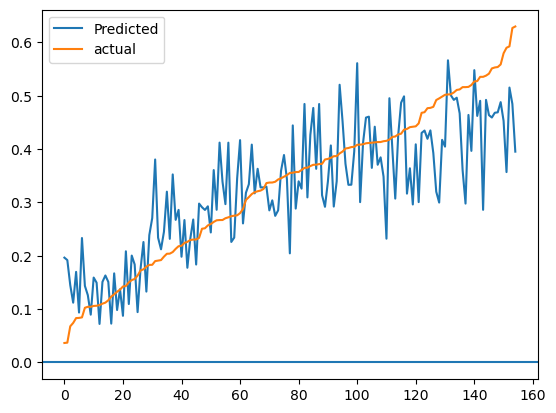

In [91]:
plt.plot(y_pred_R, linestyle=None, label = "Predicted")
plt.plot(y_test_sorted, linestyle=None, label = "actual")
plt.legend()
plt.axhline(0)
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but El

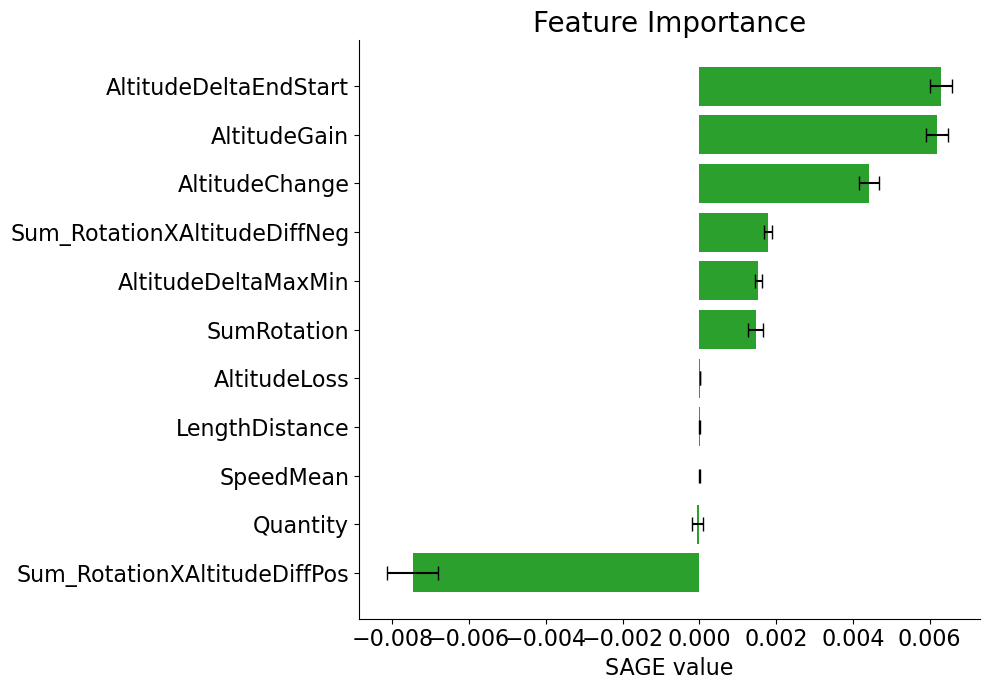

In [94]:
import sage

# Set up an imputer to handle missing features
imputer = sage.MarginalImputer(model_R, X_test_scaled_sorted.values)

# Set up an estimator
estimator = sage.PermutationEstimator(imputer, 'mse')

# Calculate SAGE values
sage_values = estimator(X_test_scaled_sorted.values, y_test_sorted)
sage_values.plot(X_feat)
plt.show()

## Linear regression

neg_mean_squared_error: 0.006 (0.001)
0.007296772704682028


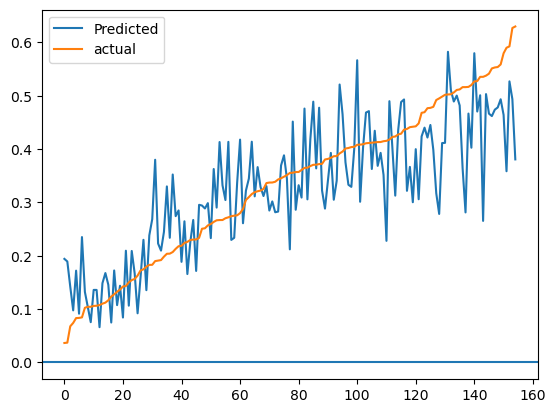

In [99]:
from sklearn.linear_model import LinearRegression

model_linear = LinearRegression()
# fit the regressor with x and y data

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores1 = cross_val_score(model_linear, 
    X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores1 = np.abs(scores1)
print(f'neg_mean_squared_error: %.3f (%.3f)' % (np.mean(scores1), np.std(scores1)))


model_linear = model_linear.fit(X_train_scaled, y_train)
y_pred_linear = model_linear.predict(X_test_scaled_sorted)

mse_linear = mean_squared_error(y_pred_linear, y_test_sorted)
print(mse_linear)

plt.plot(y_pred_linear, linestyle=None, label = "Predicted")
plt.plot(y_test_sorted, linestyle=None, label = "actual")
plt.legend()
plt.axhline(0)
plt.show()



In [96]:
y_pred_val_linear = model_linear.predict(X_val_scaled_sorted)

mse_linear_val = mean_squared_error(y_pred_val_linear, y_val_sorted)
print(mse_linear_val)

plt.plot(y_pred_val_linear, linestyle=None, label = "Predicted")
plt.plot(y_val_sorted, linestyle=None, label = "actual")
plt.legend()
plt.axhline(0)

0.004785092078424485


In [97]:
for i in range(len(X_feat)):
    print(f'{X_feat[i]}: {model_linear.coef_[0][i]}')

LengthDistance: -2523741277960.7183
Quantity: 0.02978515625
AltitudeGain: -156748244388.62042
AltitudeLoss: 54509987353.57673
AltitudeDeltaEndStart: 1.03973388671875
AltitudeChange: 139368294771.51395
AltitudeDeltaMaxMin: -0.0072021484375
Sum_RotationXAltitudeDiffPos: -0.1287841796875
Sum_RotationXAltitudeDiffNeg: 0.03289794921875
SpeedMean: 2523741277960.7227
SumRotation: 0.04570770263671875


## Random Forest

In [100]:
from hyperopt import tpe, hp, Trials
from hyperopt.fmin import fmin
from sklearn.ensemble import RandomForestRegressor
from functools import partial
from sklearn.metrics import mean_squared_error
import numpy as np

seed = 7
def objective_random(params, train_X, val_X, train_y, val_y):
    est = int(params['n_estimators'])
    md = int(params['max_depth'])
    msl = int(params['min_samples_leaf'])
    mss = int(params['min_samples_split'])
    model = RandomForestRegressor(
        n_estimators=est, max_depth=md, min_samples_leaf=msl, min_samples_split=mss)
    model.fit(train_X, train_y)
    pred = model.predict(val_X)
    score = mean_squared_error(val_y, pred)
    return score


def optimize_random(trial, train_X, val_X, train_y, val_y):
    params = {'n_estimators': hp.uniform('n_estimators', 100, 500),
              'max_depth': hp.uniform('max_depth', 5, 20),
              'min_samples_leaf': hp.uniform('min_samples_leaf', 1, 5),
              'min_samples_split': hp.uniform('min_samples_split', 2, 6),
              }

    fmin_objective = partial(objective_random, train_X=train_X, val_X=val_X,
                             train_y=train_y, val_y=val_y)

    best = fmin(fn=fmin_objective,
                space=params,
                algo=tpe.suggest,
                trials=trial,
                max_evals=20
                )
    return best


trial = Trials()
best_random = optimize_random(trial, X_train, X_test_sorted, y_train.ravel(), y_test_sorted.ravel())



100%|██████████| 20/20 [00:12<00:00,  1.61trial/s, best loss: 0.0018914168272696702]


In [101]:
best_random

{'max_depth': 12.879517601738463,
 'min_samples_leaf': 1.1694560409449082,
 'min_samples_split': 3.246279256859572,
 'n_estimators': 463.6278887826203}

In [102]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

# TODO: hyperparameters used?? - maybe nothing to do with
model_random = RandomForestRegressor(
        n_estimators=int(best_random['n_estimators']), 
        max_depth=int(best_random['max_depth']), 
        min_samples_leaf=int(best_random['min_samples_leaf']), 
        min_samples_split=int(best_random['min_samples_split']),)

# model_random = RandomForestRegressor(random_state = 0)

# fit the regressor with x and y data

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scoring = 'neg_mean_squared_error'
scores2 = cross_val_score(model_random, 
    X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

# force scores to be positive
scores2 = np.abs(scores2)
print(f'{scoring}: %.3f (%.3f)' % (np.mean(scores2), np.std(scores2)))

model_random = model_random.fit(X_train.values, y_train.ravel())

y_pred_random_test = model_random.predict(X_test_sorted)
y_pred_random_train = model_random.predict(X_train)

mse_random_test = mean_squared_error(y_pred_random_test, y_test_sorted)
mse_random_train = mean_squared_error(y_pred_random_train, y_train.ravel())

print(f'Testing error: {mse_random_test}')
print(f'Training error: {mse_random_train}')


neg_mean_squared_error: 0.002 (0.000)
Testing error: 0.0019697588610235015
Training error: 0.0003133625138366142


/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


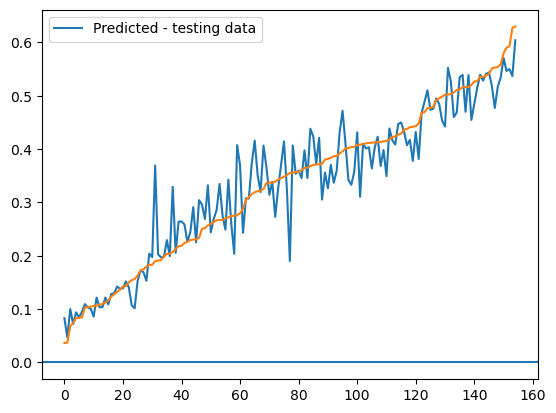

Test MSE: 0.0019697588610235015


/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


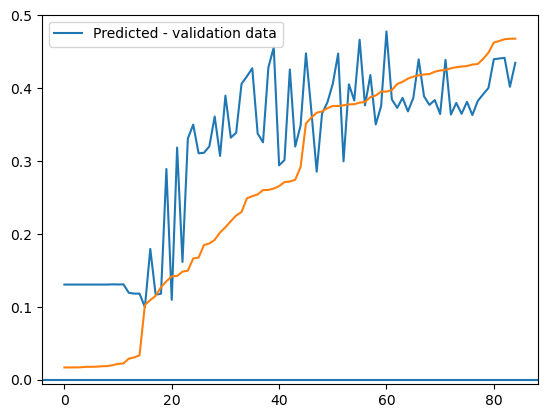

Validation MSE: 0.00873543676659816


In [103]:
plt.plot(y_pred_random_test, linestyle=None, label = "Predicted - testing data")
plt.legend()
plt.plot(y_test_sorted, linestyle=None, label = "actual")
plt.axhline(0)
plt.show()
print(f'Test MSE: {mse_random_test}')

# Plotting predicting values at validation set
y_pred_val_random_test = model_random.predict(X_val_sorted)
mse_random_val = mean_squared_error(y_pred_val_random_test, y_val_sorted)

plt.plot(y_pred_val_random_test, linestyle=None, label = "Predicted - validation data")
plt.legend()
plt.plot(y_val_sorted, linestyle=None, label = "actual")
plt.axhline(0)
plt.show()
print(f'Validation MSE: {mse_random_val}')

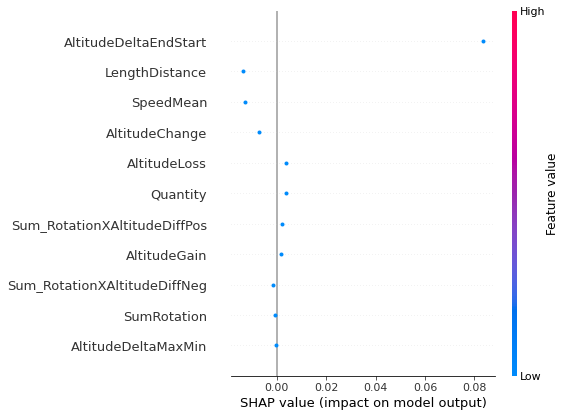

LengthDistance : 127.8135660664228
Quantity : 40.0
AltitudeGain : 4.369593772110193
AltitudeLoss : -0.09709358256498035
AltitudeDeltaEndStart : 4.272500189545212
AltitudeChange : 4.466687354675173
AltitudeDeltaMaxMin : 4.272500189545212
Sum_RotationXAltitudeDiffPos : 24.42662744404679
Sum_RotationXAltitudeDiffNeg : -0.18965629965331454
SpeedMean : 4.260452202214093
SumRotation : 155.52270644645324


PREDICTION:           0.3398
Actual value:         0.4044
TypeTripLogId: 61696d9f1d5f140000a6b886__16_0
Control, distance: 127.8135660664228
Control, distance fully: 183.70828270681122
Control, startTime: 7
Control, startTimeClock: 2021-10-15 12:06:57+00:00


In [47]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
row_to_show = 48
data_for_prediction = X_test_sorted.iloc[row_to_show].values.reshape(1, -1)
explainer_random = shap.TreeExplainer(model_random)

data_for_prediction


# Calculate Shap values
shap_values = explainer_random.shap_values(data_for_prediction)
shap.summary_plot(shap_values, data_for_prediction, feature_names = X_feat)

for a, b in zip(data_for_prediction[0], X_feat):
    print(f'{b} : {a}')

print(f'\n\nPREDICTION: {model_random.predict(data_for_prediction)[0] : 16.4f}')
print(f'Actual value: {y_test_sorted[row_to_show] : 14.4f}')
print(f"TypeTripLogId: {X_test_fact_sorted.iloc[row_to_show]['TypeTripLogId']}")
print(f"Control, distance: {X_test_fact_sorted.iloc[row_to_show]['LengthDistance']}")
print(f"Control, distance fully: {X_test_fact_sorted.iloc[row_to_show]['DistanceFullyRoute']}")
print(f"Control, startTime: {X_test_fact_sorted.iloc[row_to_show]['ControlStartTime']}")
print(f"Control, startTimeClock: {X_test_fact_sorted.iloc[row_to_show]['ControlStartTimeClock']}")


0.21589082451222225

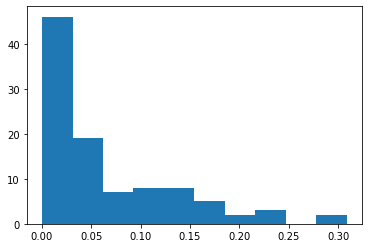

In [452]:
close = np.abs(y_test_sorted - y_pred_random_test)
plt.hist(close, bins = 10)
np.quantile(np.abs(y_pred_random_test - y_test_sorted), 0.95)


In [43]:
X_test_sorted.columns

Index(['LengthDistance', 'Quantity', 'AltitudeGain', 'AltitudeLoss',
       'AltitudeDeltaEndStart', 'AltitudeDeltaMaxMin',
       'Sum_RotationXAltitudeDiffPos', 'Sum_RotationXAltitudeDiffNeg',
       'SpeedMean', 'SumRotation'],
      dtype='object')

  0%|          | 0/1 [00:00<?, ?it/s]

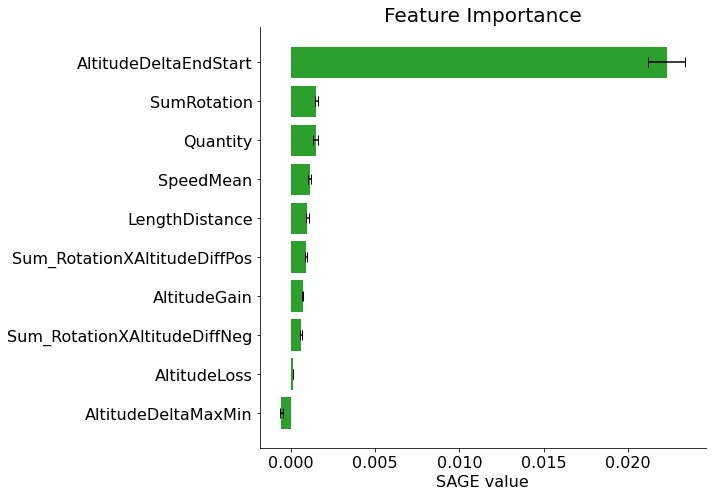

In [58]:
import sage

# Set up an imputer to handle missing features
imputer = sage.MarginalImputer(model_random, X_test_sorted.values)

# Set up an estimator
estimator = sage.PermutationEstimator(imputer, 'mse')

# Calculate SAGE values
sage_values = estimator(X_test_sorted.values, y_test_sorted)
sage_values.plot(X_feat)


## XGBoost

### Fit model

In [46]:
import xgboost as xgb
import numpy as np
from hyperopt import tpe, hp, Trials
from hyperopt.fmin import fmin
from sklearn.ensemble import RandomForestRegressor
from functools import partial
from sklearn.metrics import mean_squared_error
import numpy as np

seed = 7
def objective_xgb(params, train_X, val_X, train_y, val_y):
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    learning=params['learning_rate']

    model = xgb.XGBRegressor(n_estimators=est,max_depth=md,learning_rate=learning)
    model.fit(train_X, train_y)
    pred = model.predict(val_X)

    score = mean_squared_error(val_y, pred)
    return score


# TODO: reg_alpha, reg_lambda, gamma
def optimize_xgb(trial, train_X, val_X, train_y, val_y):
    params={'n_estimators':hp.uniform('n_estimators',2,500),
           'max_depth':hp.uniform('max_depth',2,20),
           'learning_rate':hp.uniform('learning_rate',0.001,0.1)}
    
    fmin_objective = partial(objective_xgb, train_X=train_X, val_X=val_X,
                             train_y=train_y, val_y=val_y)

    best = fmin(fn=fmin_objective,
                space=params,
                algo=tpe.suggest,
                trials=trial,
                max_evals=20
                )
    return best


trial = Trials()
best_xgb = optimize_xgb(trial, X_train, X_test_sorted, y_train.ravel(), y_test_sorted.ravel())



100%|██████████| 20/20 [00:07<00:00,  2.79trial/s, best loss: 0.0015384738121200106]


In [47]:
best_xgb

{'learning_rate': 0.07805818477411414,
 'max_depth': 19.079007196555395,
 'n_estimators': 447.99063749265133}

In [50]:
# TODO: hyperparameters used?? - maybe nothing to do with
eval_set = [(X_train, y_train), (X_test_sorted, y_test_sorted), (X_val_sorted, y_val_sorted)]

model_xgb = xgb.XGBRegressor(
    n_estimators = int(best_xgb['n_estimators']),
    max_depth = int(best_xgb['max_depth']), 
    learning_rate = best_xgb['learning_rate'], 
    early_stopping_rounds = 2
)

# model_xgb = xgb.XGBRegressor(random_state = 0)
# fit the regressor with x and y data

model_xgb = model_xgb.fit(X_train, y_train.ravel(), eval_set=eval_set, 
                        verbose = False)
                        
results = model_xgb.evals_result()

y_pred_xgb_test = model_xgb.predict(X_test_sorted)
y_pred_xgb_train = model_xgb.predict(X_train)
y_pred_xgb_val = model_xgb.predict(X_val_sorted)

mse_xgb_test = mean_squared_error(y_pred_xgb_test, y_test_sorted)
mse_xgb_train = mean_squared_error(y_pred_xgb_train, y_train.ravel())
mse_xgb_val = mean_squared_error(y_pred_xgb_val, y_val_sorted)

print(f'Testing error: {mse_xgb_test}')
print(f'Training error: {mse_xgb_train}')
print(f'Val error: {mse_xgb_val}')

Testing error: 0.0016309512723921503
Training error: 5.4457354094143544e-05
Val error: 0.0023209060504854545


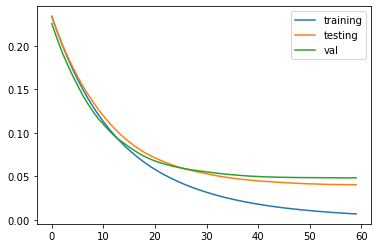

In [51]:
plt.plot(results['validation_0']['rmse'], label = "training")
plt.plot(results['validation_1']['rmse'], label = "testing")
plt.plot(results['validation_2']['rmse'], label = "val")
plt.legend()
plt.show()

### Save model

In [54]:
import pickle
XGB_path = '/Users/oysteinbruce/Documents/GitHub/SINTEF/fuel_model/models/XGB/'
filename = XGB_path + 'give_alexandra.pkl'

pickle.dump(model_xgb, open(filename, "wb"))



### Predictions

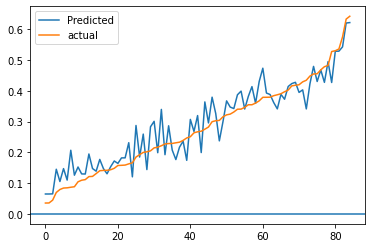

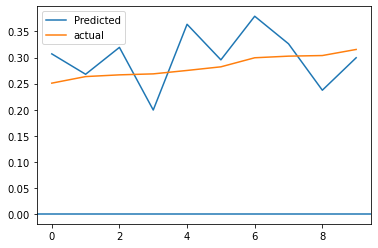

In [108]:
plt.plot(y_pred_xgb_test, linestyle=None, label = "Predicted")
plt.plot(y_test_sorted, linestyle=None, label = "actual")
plt.legend()
plt.axhline(0)
plt.show()
start_ = 40
plt.plot(y_pred_xgb_test[start_: start_ + 10], linestyle=None, label = "Predicted")
plt.plot(y_test_sorted[start_: start_ + 10], linestyle=None, label = "actual")
plt.legend()
plt.axhline(0)
plt.show()

In [53]:
import m2cgen as m2c

with open('model_new.cs', 'w') as f:
    code = m2c.export_to_c(model_xgb)
    f.write(code)


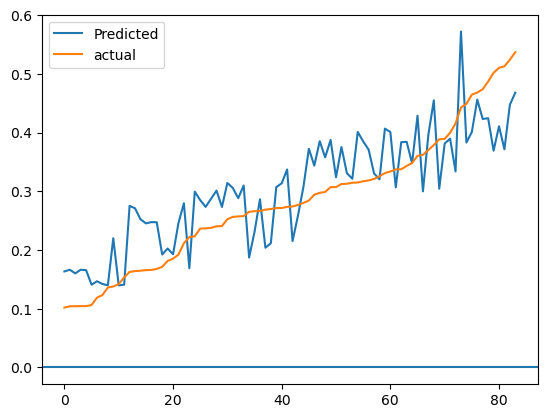

In [337]:
plt.plot(y_pred_xgb_val, linestyle=None, label = "Predicted")
plt.plot(y_val_sorted, linestyle=None, label = "actual")
plt.legend()
plt.axhline(0)
plt.show()

### Testing values, SHAP

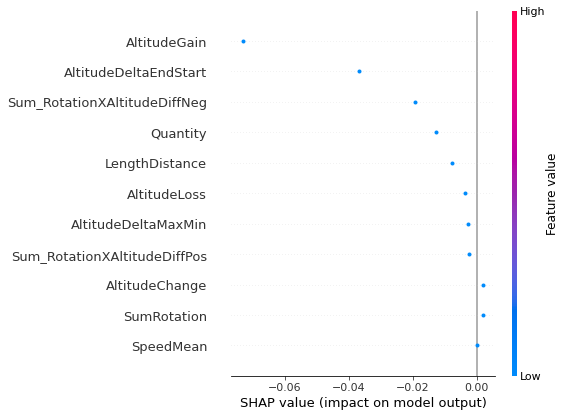

LengthDistance : 106.52322637145625
Quantity : 0.0
AltitudeGain : 0.4722084867397598
AltitudeLoss : -4.103935996050211
AltitudeDeltaEndStart : -3.6317275093104513
AltitudeChange : 4.576144482789971
AltitudeDeltaMaxMin : 4.103935996050211
Sum_RotationXAltitudeDiffPos : 8.005122625066864
Sum_RotationXAltitudeDiffNeg : -11.860115811462384
SpeedMean : 3.550774212381875
SumRotation : 146.69626813232455


PREDICTION:           0.1333
Actual value:         0.0841

TypeTripLogId: 6152f3cee4921500000afb2e__2_0
Control, distance: 106.52322637145625
Control, distance fully: 113.21534672011148
Control, startTime: 2
Control, startTimeClock: 2021-09-28 11:02:43+00:00


In [95]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
row_to_show = 5
data_for_prediction = X_test_sorted.iloc[row_to_show].values.reshape(1, -1)
explainer = shap.TreeExplainer(model_xgb)

data_for_prediction


# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.summary_plot(shap_values, data_for_prediction, feature_names = X_feat)

for a, b in zip(data_for_prediction[0], X_feat):
    print(f'{b} : {a}')

print(f'\n\nPREDICTION: {model_xgb.predict(data_for_prediction)[0] : 16.4f}')
print(f'Actual value: {y_test_sorted[row_to_show] : 14.4f}')
print(f"\nTypeTripLogId: {X_test_fact_sorted.iloc[row_to_show]['TypeTripLogId']}")
print(f"Control, distance: {X_test_fact_sorted.iloc[row_to_show]['LengthDistance']}")
print(f"Control, distance fully: {X_test_fact_sorted.iloc[row_to_show]['DistanceFullyRoute']}")
print(f"Control, startTime: {X_test_fact_sorted.iloc[row_to_show]['ControlStartTime']}")
print(f"Control, startTimeClock: {X_test_fact_sorted.iloc[row_to_show]['ControlStartTimeClock']}")


In [154]:
data_for_prediction

array([[115.33367612,   0.        ,   0.36045964,  -6.34223779,
         -5.98177815,   6.70269743,   0.49469243, -40.08901605,
          3.84445587, 139.40278184]])

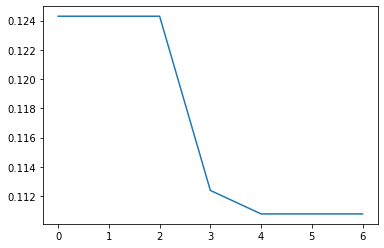



PREDICTION:           0.1124
Actual value:         0.0958


In [174]:
# # ['LengthDistance', 'Quantity', 'AltitudeGain', 'AltitudeLoss', 'AltitudeDeltaEndStart', 
# # 'AltitudeChange', 'Sum_RotationXAltitudeDiffPos', 'Sum_RotationXAltitudeDiffNeg', 'SpeedMean', 'SumRotation']

# data_for_prediction1 = data_for_prediction.copy()
# preds_list = []
# for i in range(7):

#     # data_for_prediction1[0][2] = data_for_prediction[0][2] + (-10 + i)
#     data_for_prediction1[0][5] = data_for_prediction[0][5] + (-3 + i)
#     preds = model_xgb.predict(data_for_prediction1)[0] 
#     preds_list.append(preds)

# plt.plot(preds_list)
# plt.show()


# print(f'\n\nPREDICTION: {model_xgb.predict(data_for_prediction)[0] : 16.4f}')
# print(f'Actual value: {y_test_sorted[row_to_show] : 14.4f}')


### Quantile-testing

In [112]:
# IS XGBoost better more correct at pretty sure things, and random forest better on difficult parts???
import helper

XGB = True
RANDOM = False

quantile = 0.5
if XGB: print(f'{quantile}-Quantile, XGboost:  {helper.get_diff_quantile(y_pred_xgb_test, y_test_sorted, quantile) : .4f}')
if RANDOM: print(f'{quantile}-Quantile, RANDOM FOREST:  {helper.get_diff_quantile(y_pred_xgb_test, y_test_sorted, quantile): .4f}\n')

quantile = 0.90
if XGB: print(f'{quantile}-Quantile, XGboost:  {helper.get_diff_quantile(y_pred_xgb_test, y_test_sorted, quantile) : .4f}')
if RANDOM: print(f'{quantile}-Quantile, RANDOM FOREST:  {helper.get_diff_quantile(y_pred_xgb_test, y_test_sorted, quantile): .4f}\n')

quantile = 0.99
if XGB: print(f'{quantile}-Quantile, XGboost:  {helper.get_diff_quantile(y_pred_xgb_test, y_test_sorted, quantile) : .4f}')
if RANDOM: print(f'{quantile}-Quantile, RANDOM FOREST:  {helper.get_diff_quantile(y_pred_xgb_test, y_test_sorted, quantile): .4f}\n')

if XGB: print(f'MSE, XGboost: {mse_xgb_test}')
if RANDOM: print(f'MSE, RANDOM forest: {mse_random_test}')

0.5-Quantile, XGboost:   0.0204
0.9-Quantile, XGboost:   0.0715
0.99-Quantile, XGboost:   0.1116
MSE, XGboost: 0.0018352683162576146


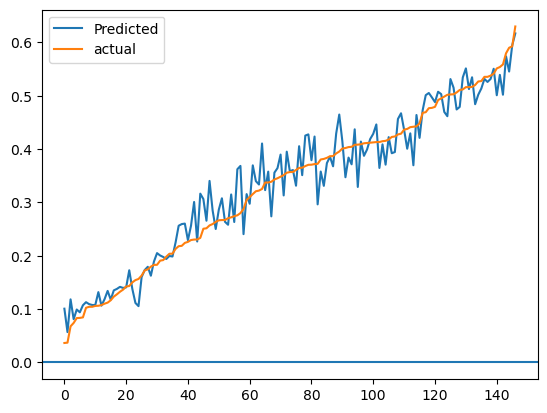

In [117]:
# plotting good quantile
quantile = 0.95
quantile_secure = np.abs(y_pred_xgb_test - y_test_sorted) < helper.get_diff_quantile(y_pred_xgb_test, y_test_sorted, quantile)
quantile_fail = np.abs(y_pred_xgb_test - y_test_sorted) > helper.get_diff_quantile(y_pred_xgb_test, y_test_sorted, quantile)


plt.plot(y_pred_xgb_test[quantile_secure], linestyle=None, label = "Predicted")
plt.plot(y_test_sorted[quantile_secure], linestyle=None, label = "actual")
plt.legend()
plt.axhline(0)
plt.show()

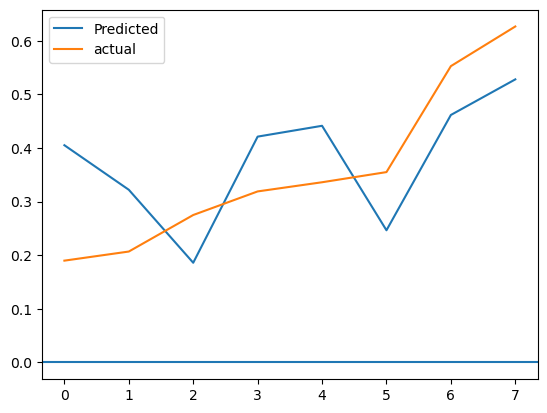

In [120]:
# plotting fail quantile

quantile = 0.95
quantile_secure = np.abs(y_pred_xgb_test - y_test_sorted) < np.quantile(np.abs(y_pred_xgb_test - y_test_sorted), quantile)
quantile_fail = np.abs(y_pred_xgb_test - y_test_sorted) > np.quantile(np.abs(y_pred_xgb_test - y_test_sorted), quantile)

plt.plot(y_pred_xgb_test[quantile_fail], linestyle=None, label = "Predicted")
plt.plot(y_test_sorted[quantile_fail], linestyle=None, label = "actual")
plt.legend()
plt.axhline(0)
plt.show()

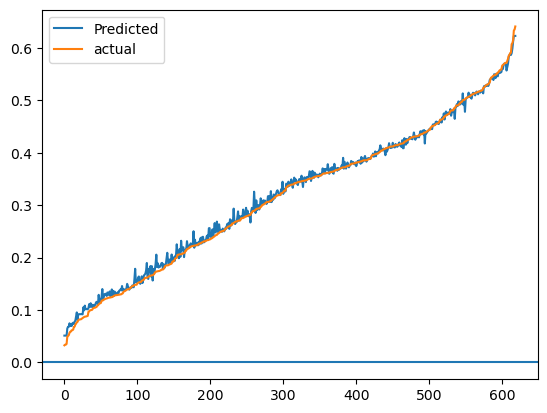

In [121]:
# plotting, training data
plt.plot(y_pred_xgb_train[np.argsort(y_train.ravel())], linestyle=None, label = "Predicted")
plt.plot(np.sort(y_train.ravel()), linestyle=None, label = "actual")
plt.legend()
plt.axhline(0)
plt.show()

### Sage

  0%|          | 0/1 [00:00<?, ?it/s]

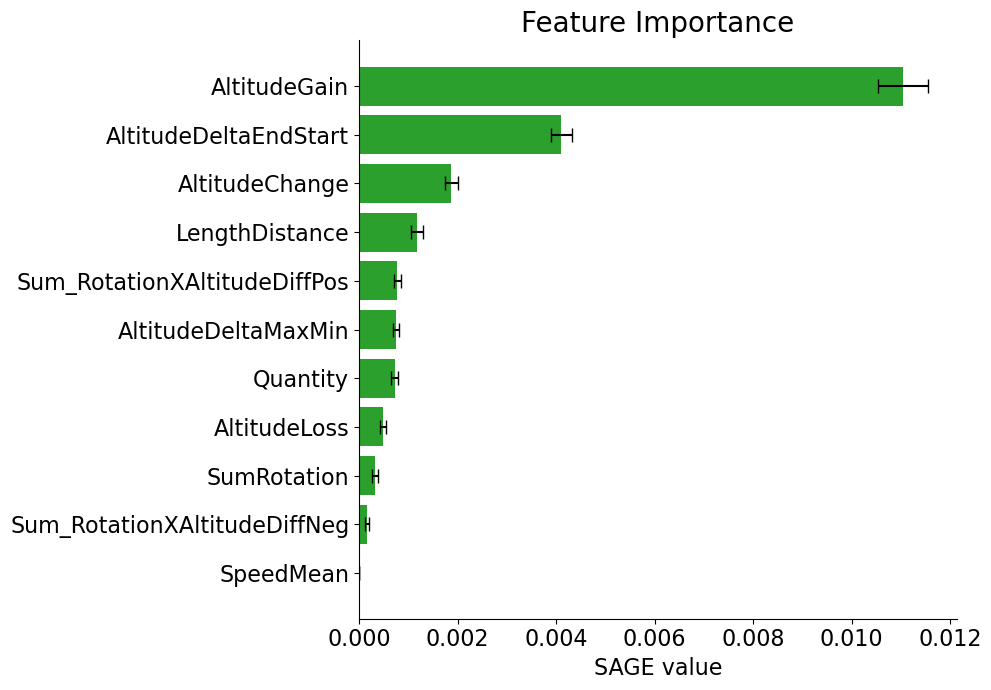

In [264]:
import sage

# Set up an imputer to handle missing features
imputer = sage.MarginalImputer(model_xgb, X_test_sorted.values)

# Set up an estimator
estimator = sage.PermutationEstimator(imputer, 'mse')

# Calculate SAGE values
sage_values = estimator(X_test_sorted.values, y_test_sorted)
sage_values.plot(X_feat)
plt.show()

In [140]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
row_to_show = 286
data_for_prediction = X_test_sorted.iloc[row_to_show].values.reshape(1, -1)
explainer = shap.TreeExplainer(model_xgb)

data_for_prediction


# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.summary_plot(shap_values, data_for_prediction, feature_names = X_feat)

for a, b in zip(data_for_prediction[0], X_feat):
    print(f'{b} : {a}')

print(f'\n\nPREDICTION: {model_xgb.predict(data_for_prediction)[0] : 16.4f}')
print(f'Actual value: {y_test_sorted[row_to_show] : 14.4f}')


IndexError: single positional indexer is out-of-bounds

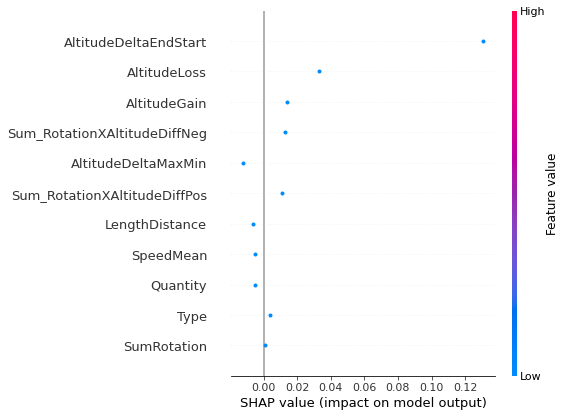

PREDICTION:           0.2923
Actual value:         0.5679
PREDICTION modified:  0.4598


In [674]:
# Change some values, what happens to prediction
data_for_prediction2 = data_for_prediction.copy()
#data_for_prediction2[0][0] =  # Switch the distance
#data_for_prediction2[0][1] = 0 # Switch the Quantity
#data_for_prediction2[0][9] = 2 # Switch the Speedmean
data_for_prediction2[0][5] = 6 # Switch the AltitudeDeltaEndStart
# data_for_prediction2[0][3] = 6 # Switch the AltitudeGain


shap_values_changed = explainer.shap_values(data_for_prediction2)
shap.summary_plot(shap_values_changed, data_for_prediction2, feature_names = X_feat)

print(f'PREDICTION: {model_xgb.predict(data_for_prediction)[0] : 16.4f}')
print(f'Actual value: {y_test_sorted[row_to_show] : 14.4f}')
print(f'PREDICTION modified: {model_xgb.predict(data_for_prediction2)[0] : 5.4f}')



# Support Vector Machines

In [127]:
import xgboost as xgb
import numpy as np
from hyperopt import tpe, hp, Trials
from hyperopt.fmin import fmin
from functools import partial
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn import svm

seed = 7
def objective_svm(params, train_X, val_X, train_y, val_y):
    degree=int(params['degree'])
    tol=params['tol']
    C=params['C']
    eps = params['epsilon']

    model = svm.SVR(degree = degree,
                    tol = tol,
                    C = C,
                    epsilon = eps)
    model.fit(train_X, train_y)
    pred = model.predict(val_X)

    score = mean_squared_error(val_y, pred)
    return score


def optimize_svm(trial, train_X, val_X, train_y, val_y):
    params={'degree':hp.uniform('degree', 1, 30),
           'tol':hp.uniform('tol',1e-7,1e-1),
           'C':hp.uniform('C',0.01,0.1),
           'epsilon':hp.uniform('epsilon',1e-4,1)}
    
    fmin_objective = partial(objective_svm, train_X=train_X, val_X=val_X,
                             train_y=train_y, val_y=val_y)

    best = fmin(fn=fmin_objective,
                space=params,
                algo=tpe.suggest,
                trials=trial,
                max_evals=200
                )
    return best


trial = Trials()
best_svm = optimize_svm(trial, X_train, X_test_sorted, y_train.ravel(), y_test_sorted.ravel())



100%|██████████| 200/200 [00:03<00:00, 61.60trial/s, best loss: 0.01001860643749158] 


In [128]:
best_svm

{'C': 0.09992155333413684,
 'degree': 13.484703040668856,
 'epsilon': 0.002445270380591627,
 'tol': 0.016993912255227808}

In [129]:
from sklearn import svm

model_svm = svm.SVR()

model_svm.fit(X_train_scaled.values, y_train.ravel())

y_pred_svm_test = model_svm.predict(X_test_scaled_sorted)
y_pred_svm_train = model_svm.predict(X_train_scaled)

mse_svm_test = mean_squared_error(y_pred_svm_test, y_test_sorted)
mse_svm_train = mean_squared_error(y_pred_svm_train, y_train.ravel())

print(f'Testing error: {mse_svm_test}')
print(f'Training error: {mse_svm_train}')


plt.plot(y_pred_svm_test, linestyle=None, label = "Predicted")
plt.plot(y_test_sorted, linestyle=None, label = "actual")
plt.legend()
plt.axhline(0)

Testing error: 0.0039480707847870545
Training error: 0.0034165207301886423


X has feature names, but SVR was fitted without feature names
X has feature names, but SVR was fitted without feature names


In [68]:
import sage

# Set up an imputer to handle missing features
imputer = sage.MarginalImputer(model_svm, X_test_sorted.values)

# Set up an estimator
estimator = sage.PermutationEstimator(imputer, 'mse')

# Calculate SAGE values
sage_values = estimator(X_test_sorted.values, y_test_sorted)
sage_values.plot(X_feat)

  0%|          | 0/1 [00:00<?, ?it/s]

NotFittedError: This SVR instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [592]:
# IS XGBoost better more correct at pretty sure things, and random forest better on difficult parts???


quantile = 0.5
print(f'{quantile}-Quantile, XGboost:  {np.quantile(np.abs(y_pred_xgb_test - y_test_sorted), quantile) : .4f}')
print(f'{quantile}-Quantile, RANDOM FOREST:  {np.quantile(np.abs(y_pred_random_test - y_test_sorted), quantile): .4f}\n')

quantile = 0.75
print(f'{quantile}-Quantile, XGboost:  {np.quantile(np.abs(y_pred_xgb_test - y_test_sorted), quantile) : .4f}')
print(f'{quantile}-Quantile, RANDOM FOREST:  {np.quantile(np.abs(y_pred_random_test - y_test_sorted), quantile): .4f}\n')

quantile = 0.95
print(f'{quantile}-Quantile, XGboost:  {np.quantile(np.abs(y_pred_xgb_test - y_test_sorted), quantile) : .4f}')
print(f'{quantile}-Quantile, RANDOM FOREST:  {np.quantile(np.abs(y_pred_random_test - y_test_sorted), quantile): .4f}\n')

quantile = 0.99
print(f'{quantile}-Quantile, XGboost:  {np.quantile(np.abs(y_pred_xgb_test - y_test_sorted), quantile) : .4f}')
print(f'{quantile}-Quantile, RANDOM FOREST:  {np.quantile(np.abs(y_pred_random_test - y_test_sorted), quantile): .4f}\n')

print(f'MSE, XGboost: {mse_xgb_test}')
print(f'MSE, RANDOM forest: {mse_random_test}')

0.5-Quantile, XGboost:   0.0074
0.5-Quantile, RANDOM FOREST:   0.0185

0.5-Quantile, RANDOM FOREST:   0.0185

0.75-Quantile, XGboost:   0.0326
0.75-Quantile, RANDOM FOREST:   0.0446

0.95-Quantile, XGboost:   0.1114
0.95-Quantile, RANDOM FOREST:   0.1326

0.99-Quantile, XGboost:   0.1721
0.99-Quantile, RANDOM FOREST:   0.1817

MSE, XGboost: 0.0021734002874327927
MSE, RANDOM forest: 0.0028395640756576344


# NN pytorch

In [245]:
scaled_output = True
if scaled_output:
    NN_y_train = y_train_scaled
    NN_y_test = y_test_scaled_sorted
    NN_y_val = y_val_scaled_sorted
else: 
    NN_y_train = y_train
    NN_y_test = y_test_sorted
    NN_y_val = y_val_sorted

scaled_input = True
if scaled_input:
    NN_X_train = X_train_scaled
    NN_X_test = X_test_scaled_sorted
    NN_X_val = X_val_scaled_sorted
else:
    NN_X_train = X_train
    NN_X_test = X_test_sorted
    NN_X_val = X_val_sorted


In [246]:
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader, Dataset  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!


input_size = len(X_feat)

class Net(nn.Module):
    def __init__(self, input_size, num_classes):
      super(Net, self).__init__()

      # First fully connected layer
      self.fc1 = nn.Linear(input_size, 10)
      self.fc2 = nn.Linear(10, 30)
    #   self.fc3 = nn.Linear(30, 50)

      # self.fc4 = nn.Linear(100, 70)
      self.fc5 = nn.Linear(30, 10)
      self.fc6 = nn.Linear(10, num_classes)
      
      self.dropout = nn.Dropout(p = 0.2)

    def forward(self, x):
      x = self.fc1(x)
      x = self.dropout(x)
      x = F.relu(x)

      x = self.fc2(x)
      x = self.dropout(x)
      x = F.relu(x)
      
    #   x = self.fc3(x)
    #   x = self.dropout(x)
    #   x = F.relu(x)

      # x = self.fc4(x)
      # x = self.dropout(x)
      # x = F.relu(x)

      x = self.fc5(x)
      x = self.dropout(x)
      x = F.relu(x)

      x = self.fc6(x)

      return x

class MyDataset(Dataset):
    def __init__(self, X_tensor, y_tensor):
        self.x_tensor = X_tensor
        self.y_tensor = y_tensor
    def __len__(self):
        return len(self.y_tensor)
    def __getitem__(self, idx):
        return self.x_tensor[idx], self.y_tensor[idx]

In [247]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

settings = {'input_size': len(X_feat),
            'num_classes': 1,
            'learning_rate': 0.001,
            'batch_size': 20,
            'num_epochs': 50}

X_train_tensor = torch.tensor(NN_X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(NN_X_test.values, dtype=torch.float32)
X_val_tensor = torch.tensor(NN_X_val.values, dtype=torch.float32)

y_train_tensor = torch.tensor(NN_y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(NN_y_test, dtype=torch.float32)
y_val_tensor = torch.tensor(NN_y_val, dtype=torch.float32)

model = Net(input_size=settings['input_size'],
            num_classes=settings['num_classes']).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=settings['learning_rate'])


train_loader = DataLoader(dataset=MyDataset(X_train_tensor, y_train_tensor), 
                          batch_size=settings['batch_size'],
                          shuffle=True)
test_loader = DataLoader(dataset=MyDataset(X_test_tensor, y_test_tensor),
                         batch_size=settings['batch_size'],
                         shuffle=False)
val_loader = DataLoader(dataset=MyDataset(X_val_tensor, y_val_tensor),
                         batch_size=settings['batch_size'],
                         shuffle=False)





In [248]:
#TODO: hyperparameter optimizatoin

In [249]:
def check_MSE(X_tensor, y_numpy, model):
    model.eval()

    with torch.no_grad():
        scores = model(X_tensor).cpu().detach().numpy()


    model.train()
    return mean_squared_error(scores, y_numpy)


In [250]:
MSE_train = []
MSE_test = []
MSE_val = []

# Train Network
model.train()
for epoch in (pbar := tqdm(range(settings['num_epochs']))):
    for batch_idx, (data, targets) in enumerate(train_loader):

        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Get to correct shape
        data = data.reshape(data.shape[0], -1)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    
    MSE_train.append(check_MSE(X_train_tensor, NN_y_train, model))
    MSE_test.append(check_MSE(X_test_tensor, NN_y_test, model))
    MSE_val.append(check_MSE(X_val_tensor, NN_y_val, model))

    pbar.set_description(f"Train: {MSE_train[epoch] : .4f}, Test: {MSE_test[epoch]: .4f}, Val: {MSE_val[epoch]: .4f}")

    



Train:  0.1475, Test:  0.1581, Val:  0.3932: 100%|██████████| 50/50 [00:01<00:00, 41.36it/s]


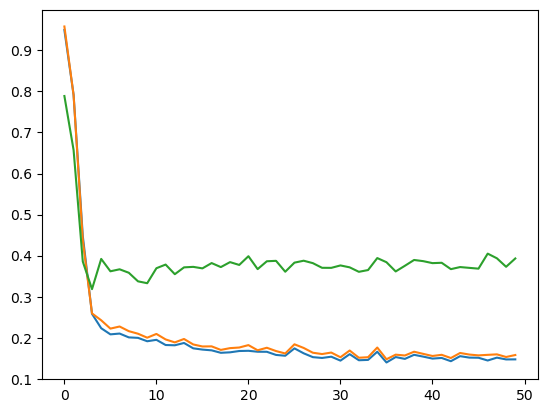

In [251]:
plt.plot(MSE_train)
plt.plot(MSE_test)
plt.plot(MSE_val)
plt.show()

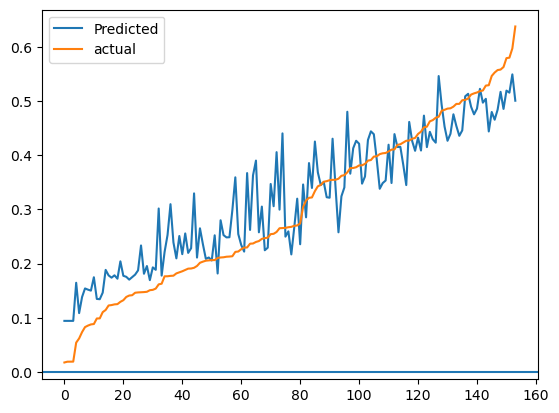

0.0035700002657339763

In [252]:
model.eval()
preds = model(X_test_tensor).cpu().detach().numpy()
if scaled_output:
    preds = sc_y.inverse_transform(preds).reshape(preds.shape[0])
else:
    preds = preds.reshape(preds.shape[0])

plt.plot(preds, linestyle=None, label = "Predicted")
plt.plot(y_test_sorted, linestyle=None, label = "actual")
plt.legend()
plt.axhline(0)
plt.show()
mean_squared_error(preds, y_test_sorted)


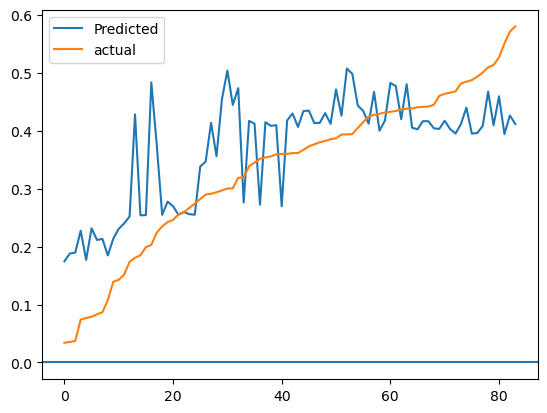

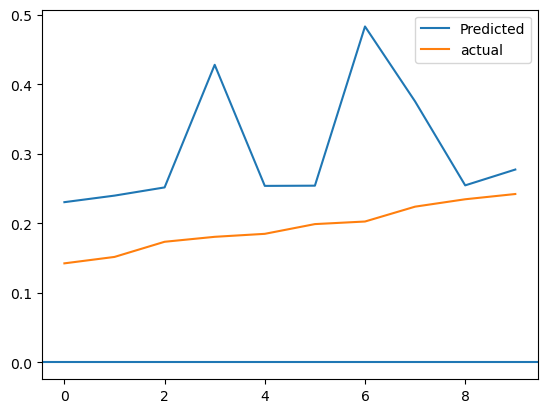

0.00887610521709642

In [256]:
model.eval()
preds = model(X_val_tensor).cpu().detach().numpy()
if scaled_output:
    preds = sc_y.inverse_transform(preds).reshape(preds.shape[0]) # scaled output
else:
    preds = preds.reshape(preds.shape[0]) 

plt.plot(preds, linestyle=None, label = "Predicted")
plt.plot(y_val_sorted, linestyle=None, label = "actual")
plt.legend()
plt.axhline(0)
plt.show()

start = 10

plt.plot(preds[start:start+10], linestyle=None, label = "Predicted")
plt.plot(y_val_sorted[start:start+10], linestyle=None, label = "actual")
plt.legend()
plt.axhline(0)
plt.show()

mean_squared_error(preds, y_val_sorted)

In [258]:
## JUST WORKING FOR SCALED OUTPUT
if scaled_output:
    row_to_show = 15
    data_for_prediction = X_val_tensor[row_to_show]

    # data_for_prediction = torch.reshape(data_for_prediction, (-1, ))
    preds = model.forward(data_for_prediction).detach().numpy()
    if scaled_output:
        preds = sc_y.inverse_transform(preds.reshape(-1, 1))

    for a, b in zip(X_val_sorted.iloc[row_to_show], X_feat):
        print(f'{b} : {a}')

    print(f'\n\nPREDICTION: { preds[0][0]: 16.4f}')
    print(f'Actual value: {y_val_sorted[row_to_show] : 14.4f}')
    print(f"\nTypeTripLogId: {X_val_fact_sorted.iloc[row_to_show]['TypeTripLogId']}")
    print(f"Control, distance: {X_val_fact_sorted.iloc[row_to_show]['LengthDistance']}")
    print(f"Control, distance fully: {X_val_fact_sorted.iloc[row_to_show]['DistanceFullyRoute']}")
    print(f"Control, startTime: {X_val_fact_sorted.iloc[row_to_show]['ControlStartTime']}")
    print(f"Control, startTimeClock: {X_val_fact_sorted.iloc[row_to_show]['ControlStartTimeClock']}")

LengthDistance : 132.21559393237254
Quantity : 0.0
AltitudeGain : 2.2088887937881054
AltitudeLoss : -0.6464057213796082
AltitudeDeltaEndStart : 1.573441968899715
AltitudeChange : 2.8552945151677136
AltitudeDeltaMaxMin : 2.219847690279323
Sum_RotationXAltitudeDiffPos : 8.93270412600293
Sum_RotationXAltitudeDiffNeg : -6.721252163050208
SpeedMean : 4.407186464412418
SumRotation : 196.27530933318104


PREDICTION:           0.2544
Actual value:         0.1991

TypeTripLogId: 616ee038fc6f1e000016cf75__22_1
Control, distance: 132.21559393237254
Control, distance fully: 146.58514807706558
Control, startTime: 5
Control, startTimeClock: 2021-10-19 15:33:03+00:00


Setting up imputer for PyTorch model, assuming that any necessary output activations are applied properly. If not, please set up nn.Sequential with nn.Sigmoid or nn.Softmax


  0%|          | 0/1 [00:00<?, ?it/s]

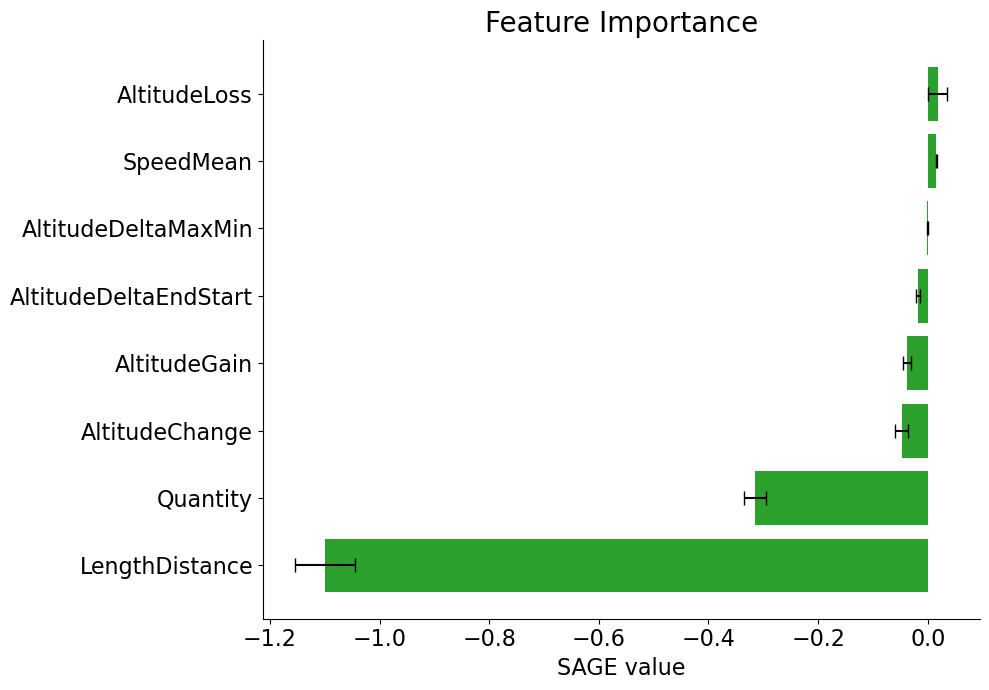

In [184]:
import sage

# Set up an imputer to handle missing features
imputer = sage.MarginalImputer(model, X_test_sorted.values)

# Set up an estimator
estimator = sage.PermutationEstimator(imputer, 'mse')

# Calculate SAGE values
sage_values = estimator(X_test_sorted.values, y_test_sorted)
sage_values.plot(X_feat)
plt.show()

In [381]:
diff = np.abs(preds - y_val_sorted)
np.quantile(diff, 1)

0.23736032254960793

# Other

## NN - Signe

In [45]:
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from IPython.display import clear_output

In [46]:
dropout_frac = 0.15
number_neurons1 = 20
number_neurons2 = 12
number_neurons3 = 20

model_NN = Sequential()
model_NN.add(Dense(units=number_neurons1, activation='relu', input_dim=X_train.shape[1]))
model_NN.add(Dropout(dropout_frac))  # Preventing overfitting
model_NN.add(Dense(units=number_neurons2, activation='relu'))
model_NN.add(Dropout(dropout_frac))  # Preventing overfitting
model_NN.add(Dense(units=number_neurons3, activation='relu'))
model_NN.add(Dropout(dropout_frac))  # Preventing overfitting
model_NN.add(Dense(units=y_train.shape[1], activation='linear'))

model_NN.compile(loss='mean_squared_error', optimizer='adam') #metrics=['accuracy'], 

2022-08-10 08:56:23.126430: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [47]:
training_history = model_NN.fit(X_train_scaled, y_train_scaled, 
                             epochs=200,                  
                             batch_size=25,    
                             validation_split=0.2,
                             #callbacks=[plot_losses]
                               )

2022-08-10 08:56:23.324845: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
23/23 [==============================] - 0s 6ms/step - loss: 1.1942 - val_loss: 0.8917
Epoch 2/200
23/23 [==============================] - 0s 2ms/step - loss: 0.8705 - val_loss: 0.7097
Epoch 3/200
23/23 [==============================] - 0s 2ms/step - loss: 0.7663 - val_loss: 0.6056
Epoch 4/200
23/23 [==============================] - 0s 2ms/step - loss: 0.7288 - val_loss: 0.5305
Epoch 5/200
23/23 [==============================] - 0s 2ms/step - loss: 0.6899 - val_loss: 0.4870
Epoch 6/200
23/23 [==============================] - 0s 2ms/step - loss: 0.6665 - val_loss: 0.4458
Epoch 7/200
23/23 [==============================] - 0s 2ms/step - loss: 0.6239 - val_loss: 0.4312
Epoch 8/200
23/23 [==============================] - 0s 2ms/step - loss: 0.6129 - val_loss: 0.4021
Epoch 9/200
23/23 [==============================] - 0s 2ms/step - loss: 0.6066 - val_loss: 0.3878
Epoch 10/200
23/23 [==============================] - 0s 2ms/step - loss: 0.5955 - val_loss: 0.3851
Epoch 11/

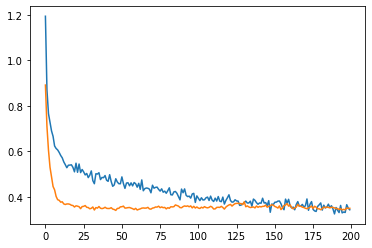

In [48]:
%matplotlib inline

plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])

In [49]:
y_scaled_NN = model_NN.predict(X_test_scaled_sorted.values).flatten()  # Predicting
#y_pred_NN = pd.DataFrame(sc_y.inverse_transform(y_scaled), columns=y_feat)  # Rescaling

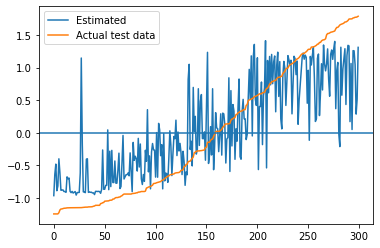

In [50]:
plt.plot(y_scaled_NN, label = 'Estimated')
plt.plot(y_test_sorted, label = 'Actual test data')
plt.axhline(0)
plt.legend()

In [51]:
mse_NN = np.sum((y_scaled_NN-y_test_sorted)**2)/len(y_scaled_NN)
print(mse_NN)

0.3145590268159916


In [52]:
## Feature importance with SAGE

In [53]:
import sage
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [66]:
# Set up an imputer to handle missing features
imputer = sage.MarginalImputer(model_NN, X_test_scaled_sorted.values)

# Set up an estimator
estimator = sage.PermutationEstimator(imputer, 'mse')

# Calculate SAGE values
sage_values = estimator(X_test_scaled_sorted.values, y_test_sorted)
sage_values.plot(X_feat)

NameError: name 'model_NN' is not defined